In [24]:
import numpy as np
import pandas as pd
import ipdb
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp 
from mpl_toolkits.mplot3d import Axes3D
import nbimporter
from Kuramoto_dynamicalModels import *
from sklearn.neighbors import NearestNeighbors
from numpy.linalg import norm

In [25]:
def make_manifold_point(X,E,tau,t):
    '''
    Creates point on a manifold embedded in R^E by time
    delaying the time series X by tau
    
    Args:
        X: Time series
        E: Dimension of embedding space
        tau: time delay
        t: a time point between (E-1)*tau < t < L
    Returns:
        X[range_revered_iterable]: a point in R^E.
    '''
    
    L = X.shape[0]
    range_iterable = range(t-(E-1)*tau,t+tau,tau)
    range_revered_iterable = list(reversed(range_iterable))
    return X[range_revered_iterable]

def make_manifold(X,E,tau):
    '''
    Creates a manifold embedded in R^E by time
    delaying the time series X by tau
    
    Args:
        X: Time series
        E: Dimension of embedding space
        tau: time delay
        
    Returns:
        embedding_x: a array of L - (E-1)*tau points
                    in R^E.
    '''
    
    # get length of time series
    L = X.shape[0]
    
    # initialize the embedding array matrix
    embedding_x =np.zeros((L - (E-1)*tau,E))
    
    i=0
    # create embedding matrix
    for t in range((E-1)*tau,L):
        # create a sequence of numbers between t-(E-1)*tau
        # and t+tau spaced by tau
    
        range_iterable = range(t-(E-1)*tau,t+tau,tau)
        
        #reverse the order of the sequence and coerce in a list
        range_revered_iterable = list(reversed(range_iterable))
        
        
        #put the entries of X at indices, range_revered_iterable,
        #in the ith row of embedding_x
        
        embedding_x[i,:] = X[range_revered_iterable]
        i+=1
    return embedding_x

def weight_function(distance):
    '''
    Exponentially weighted distance function
    
    Args:
        distance: a vector of distances
    Returns:
        u_i: normalized exponential weights
    '''
    
    non_indices=np.nonzero(distance)[0]
    if len(non_indices) == 0:
        norm_distance = 1
    else:
        norm_distance = distance[non_indices[0]]
    weighted_distance = np.exp(-distance/norm_distance)
    u_i = weighted_distance/np.sum(weighted_distance)
    return u_i


def generate_convergent_cross_approx(X,Y,E,tau):
    '''
    Approximates Y from X by 1) creating an embedding
    manifold of X, 2) mapping the neighbours of each point
    in the embedding manifold of X to the embedding manifold of 
    Y, 3) taking a exponetially weighted average of entries of 
    time series of Y associated the mapped neighbours.
    
    Args:
        X: time series used to estimate Y
        Y: time series to be estimated
        E: embedding dimension
        tau: time shift
        
    Returns:
        Y_approx: a L - (E-1)*tau time series appromixating
                  the last L - (E-1)*tau entries of Y.
    '''
    
    #makes X manifold

    xhat=make_manifold(X,E,tau)
    #number of time points to be approximated
    num_time_points = xhat.shape[0]
    
    #Initialized KNN object with xhat 
    nbrs = NearestNeighbors(n_neighbors=E+1, algorithm='ball_tree').fit(xhat)    
    
    # Computes the distance and indices of the E+1
    # nearest points of each point in xhat
    distances, indices = nbrs.kneighbors()
    
    # initial Y_approx
    Y_approx = np.zeros(num_time_points)
    
    #TODO: What about first (E-1)*tau points? I can still approximate the
    #using the last column of xhat
    for i in range(0,num_time_points):
        #computes the weight function
        u_i = weight_function(distances[i])
        #computes y approx
        Y_approx[i]= np.dot(Y[indices[i] + (E-1)*tau],u_i)
    return Y_approx

def generate_single_correlation_plot(X,Y,E,tau,sample_size=100):
    '''
    Produces correlations between CCM predictors of X and Y as a function
    of data length. 
 
    Both X and Y should have a length at least sample_size*(E+1). 

    Args:
        X: a time series to be estimated
        Y: a time series to be estimated
        E: embedding dimension
        tau: time shift
        
        
    Returns:
        L: sequence of data lengths used to calculate correlations
        rho_X: rho_X(i) is correlation between CCM predicted X and actual X.
               To calculate rho_X(i), X and Y were evenly sampled to be of length L(i).
               CCM predicted X was caluated from the sampled X and Y.
               
        rho_Y: rho_Y(i) is correlation between CCM predicted Y and actual Y.
               To calculate rho_Y(i), X and Y were evenly sampled to be of length L(i).
               CCM predicted X was caluated from the sampled X and Y.
               
    '''
    # Y and X should have equal shape
    len_total = X.shape[0]
    
    #initialize sample length
    sample_len = sample_size
    
    #intialize correlation and L vectors 
    rho_X = []
    rho_Y = []
    L = []
    #compute correlation for increasing length
    while(sample_len < len_total):
        
        #sample indices evenly
        idx = np.round(np.linspace(0, len_total-1, sample_len)).astype(int)
        
        #sample X and Y
        sample_X = X[idx]
        sample_Y = Y[idx]

        #predict Y with X
        CCM_Y = generate_convergent_cross_approx(sample_X,sample_Y,E,tau)
        #compute correlations of \hat{Y} and Y
        corr_Y = np.corrcoef(CCM_Y,sample_Y[(E-1)*tau:])
        rho_Y.append(corr_Y[0,1])

        #predict X with Y
        CCM_X = generate_convergent_cross_approx(sample_Y,sample_X,E,tau)
        #compute correlations of \hat{Y} and Y
        corr_X = np.corrcoef(CCM_X,sample_X[(E-1)*tau:])
        rho_X.append(corr_X[0,1])
        
        #store sampling length
        L.append(sample_len)
        #increace sampling length
        sample_len += sample_size
        
    return [L,rho_X,rho_Y]

def generate_phase_plane_plots(plt,y,names):
    '''
    Creates a grid of phase plots of y[i] vs y[j]
    
    Args:
        plt: a cleared matplotlib object
        y: a time series from a dynamical system
        names: list containing the names of each state variable
    
    '''
    #create empty subplots
    num_subplots = y.shape[0]
    fig, ax = plt.subplots(nrows=num_subplots, ncols=num_subplots)
    
    for i in range(num_subplots):
        for j in range(num_subplots):
            #fill offdiagonal subplots
            if i != j:
                ax[i,j].plot(y[i,:], y[j,:],linewidth=3.0)
                ax[i,j].set_xlabel('$'+names[i]+'$',fontsize = 20.0)
                ax[i,j].set_ylabel('$'+names[j]+'$',fontsize = 20)
                ax[i,j].tick_params(axis = 'both',labelsize = 15)
            j+=1
        i+=1
    plt.show()
    
def generate_multiple_correlation_plots(plt,y,E,tau,names,filename=None,sample_size=100):
    '''
    Creates a grid of correlation plots vs length of data.
    Correlation is calculated as the correlation between 
    y[i] xmap y[j] vs the actuakl y[i]
    
    Args:
        plt: a cleared matplotlib object
        y: a time series from a dynamical system
        E: embedding dimension
        tau: time shift
        names: list containing the names of each state variable
    '''

    #create empty subplots
    num_subplots = y.shape[0]
    fig, ax = plt.subplots(nrows=num_subplots, ncols=num_subplots)    
    
#     fig2 = plt.figure()
#     ax2 = fig2.add_subplot(222)
#     legend2 = []
    for i in range(num_subplots):
        for j in range(i+1,num_subplots):
            
            #generate correlations
            
            [L,rho_Yi,rho_Yj] = generate_single_correlation_plot(y[i,:],y[j,:],E,tau,sample_size)

            
            #plot correlation, calculated with y[i] xmap y[j] and y[j], as function of length
            ax[i,j].plot(L, rho_Yi,'-o',linewidth=3.0)
            plot_name_ij = '$' + names[i] + '|M_{' + names[j] + '}$'
            ax[i,j].set_xlabel('L',fontsize = 15.0)
            ax[i,j].set_ylabel('$\\rho$',fontsize = 15.0)
            ax[i,j].set_title(plot_name_ij,fontsize = 15.0)
            ax[i,j].set_ylim([-1.1,1.1])
            ax[i,j].tick_params(axis = 'both',labelsize = 15)
            
            #plot correlation, calculated with y[j] xmap y[i] and y[j], as function of length
            ax[j,i].plot(L, rho_Yj,'-o',linewidth=3.0)
            plot_name_ji = '$' + names[j] + '|M_{' + names[i] + '}$'
            ax[j,i].set_xlabel('L',fontsize = 15.0)
            ax[j,i].set_ylabel('$\\rho$',fontsize = 15.0)
            ax[j,i].set_title(plot_name_ji,fontsize = 15.0)
            ax[j,i].set_ylim([-1.1,1.1])
            ax[j,i].tick_params(axis = 'both',labelsize = 15)
            
            
#             #put all one plot
#             ax2.plot(L, rho_Yj,'-o',linewidth=3.0)
#             ax2.plot(L, rho_Yi,'-o',linewidth=3.0)
#             ax2.set_xlabel('L',fontsize = 20.0)
#             #ax2.set_ylabel('$\rho$',fontsize = 20.0)
#             ax2.tick_params(axis = 'both',labelsize = 15)
#             legend2.append(plot_name_ij)
#             legend2.append(plot_name_ji)
            
    #set legend for second plot
#     ax2.legend(legend2)
#     ax2.set_ylim([-1.1,1.1])
    if filename:
        fig.savefig(filename+'pairwise_correlation_subplots.jpg',bbox_inches='tight')
#         fig2.savefig(filename+'pairwise_all_correlations.jpg',bbox_inches='tight')

    plt.show()

# Strong Coupling

In [26]:
# these are our constants
N = 5  # number of variables
K = 10 #coupling
omega =  np.array([ 2.31246433, 35.50794494, 53.41350736, 50.23353682,  5.63392492])  # natural frequency
theta0 = np.array([1.1735002435, 2.6194283291, 2.6006912657, 2.9369995793,2.3511319532]) # initial state 
tinit = 0.0
tmax = 10.0
dt =  0.01

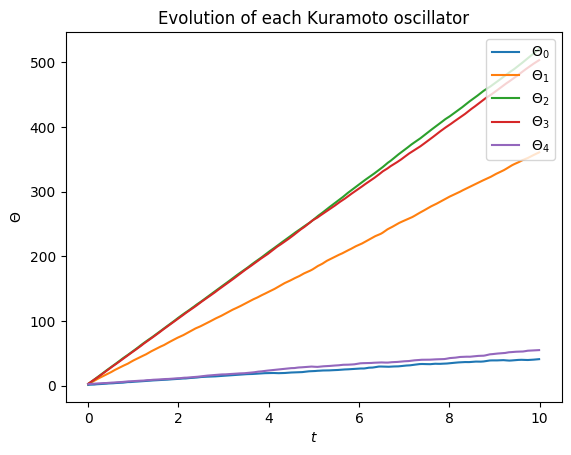

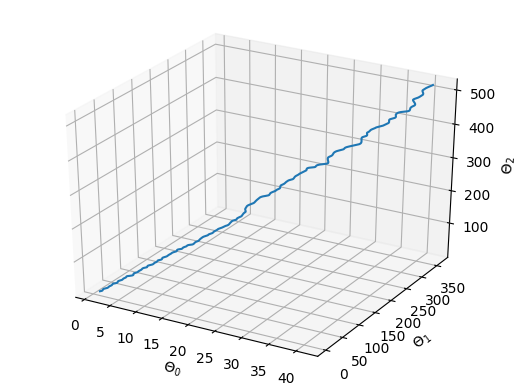

In [27]:
plt.clf()
plt.close()
kuramoto = Kuramoto(N,K,omega)
sol = kuramoto.integrate(tinit, tmax, dt, theta0)
kuramoto.evolution_plot()
kuramoto.trajectory_plot()

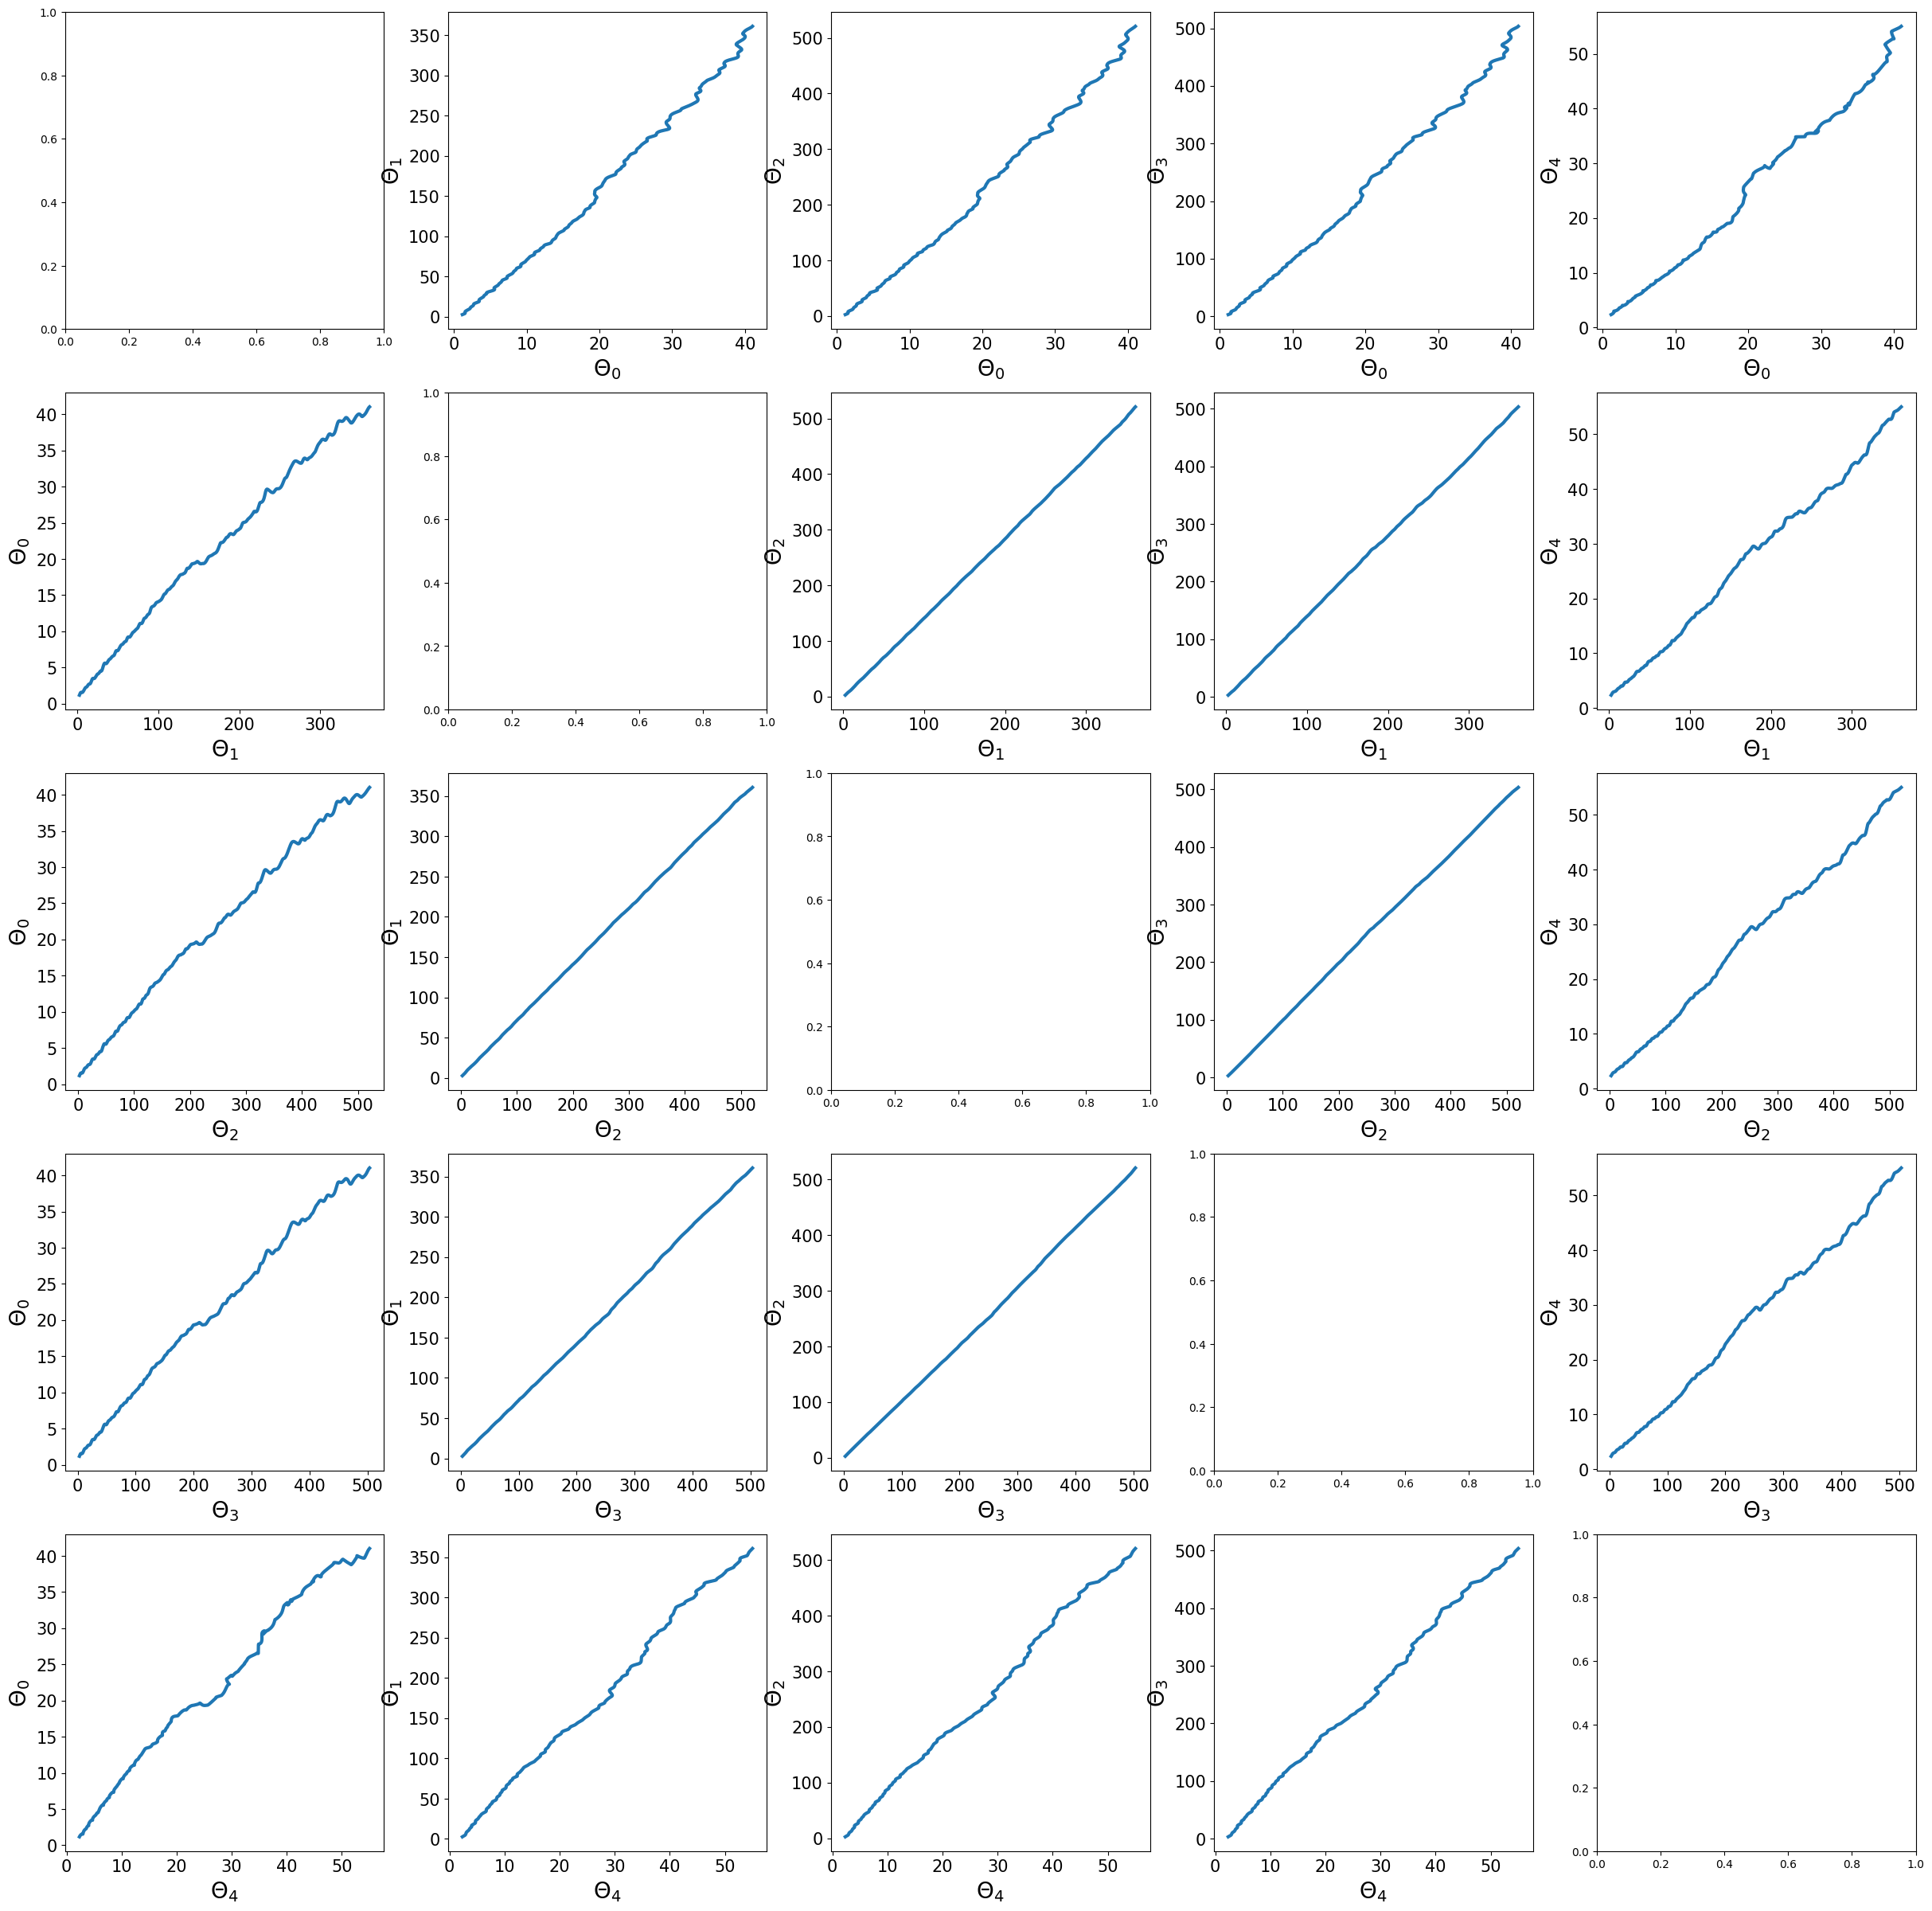

In [28]:
#reset plot 
plt.cla()
plt.clf()
plt.close()

plt.rcParams['figure.figsize'] = [30,30]

# generate_phase_plane_plots parameters
y = sol[1].T
total_len =y.shape[1]
names =  ['\Theta_0','\Theta_1', '\Theta_2','\Theta_3','\Theta_4']

generate_phase_plane_plots(plt,y,names)

# Correlation Plots

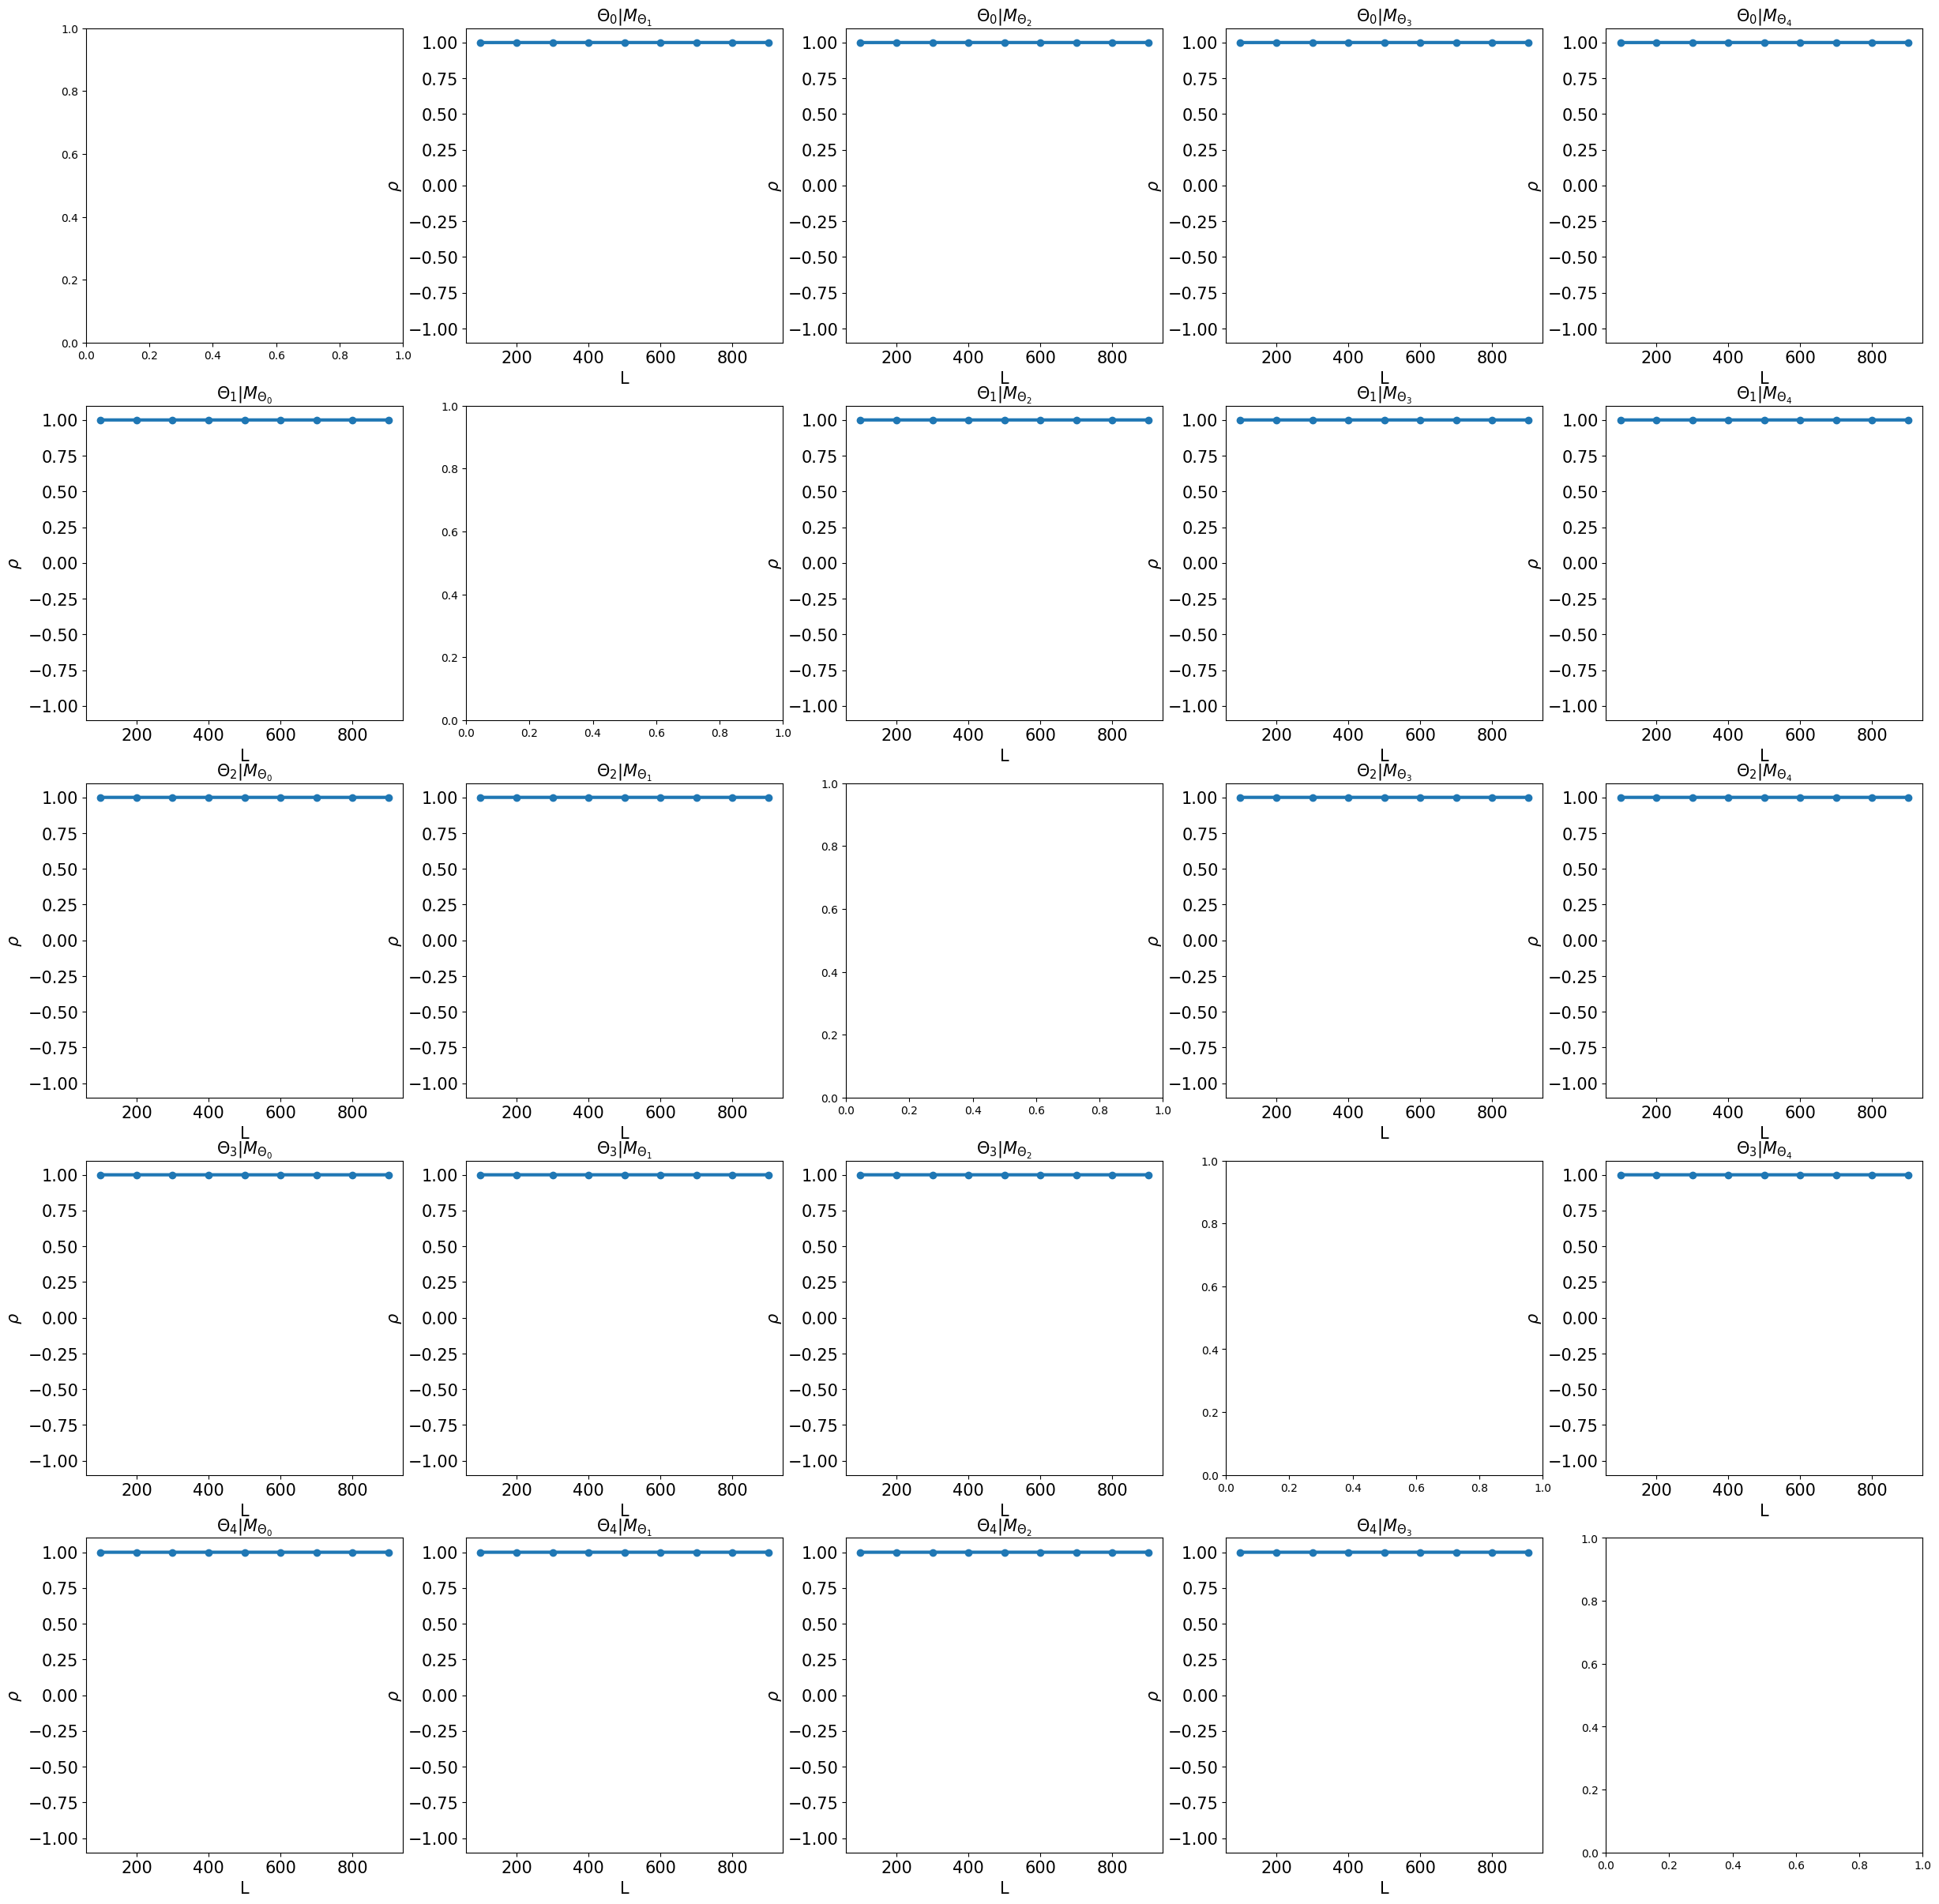

In [29]:
#reset plots
plt.cla()
plt.clf()
plt.close()

#plot parameters
plt.rcParams['figure.figsize'] = [30,30]

#parameters for generate_multiple_correlation_plots
names = ['\Theta_0','\Theta_1', '\Theta_2','\Theta_3','\Theta_4']
E=2*N+1
tau=1
filename = '/Users/aarcher/PycharmProjects/Data Driven Dynamical Systems/Kuramoto/pictures/strong_coupling_kuramoto'
generate_multiple_correlation_plots(plt,y,E,tau,names,filename)

# Transformed Problem

In [30]:
kuramoto_df = pd.DataFrame(data= sol[1],    
                columns=['\Theta_0','\Theta_1','\Theta_2','\Theta_3','\Theta_4'])
kuramoto_transform_df = kuramoto_df.transform([np.cos,np.sin])
kuramoto_transform_df.columns = [''.join(['\\' + col[1] + col[0]]).strip() for col in kuramoto_transform_df.columns.values]

In [31]:
names = kuramoto_transform_df.columns.values
y_transform = (kuramoto_transform_df.values).T
#reset plots
plt.cla()
plt.clf()
plt.close()

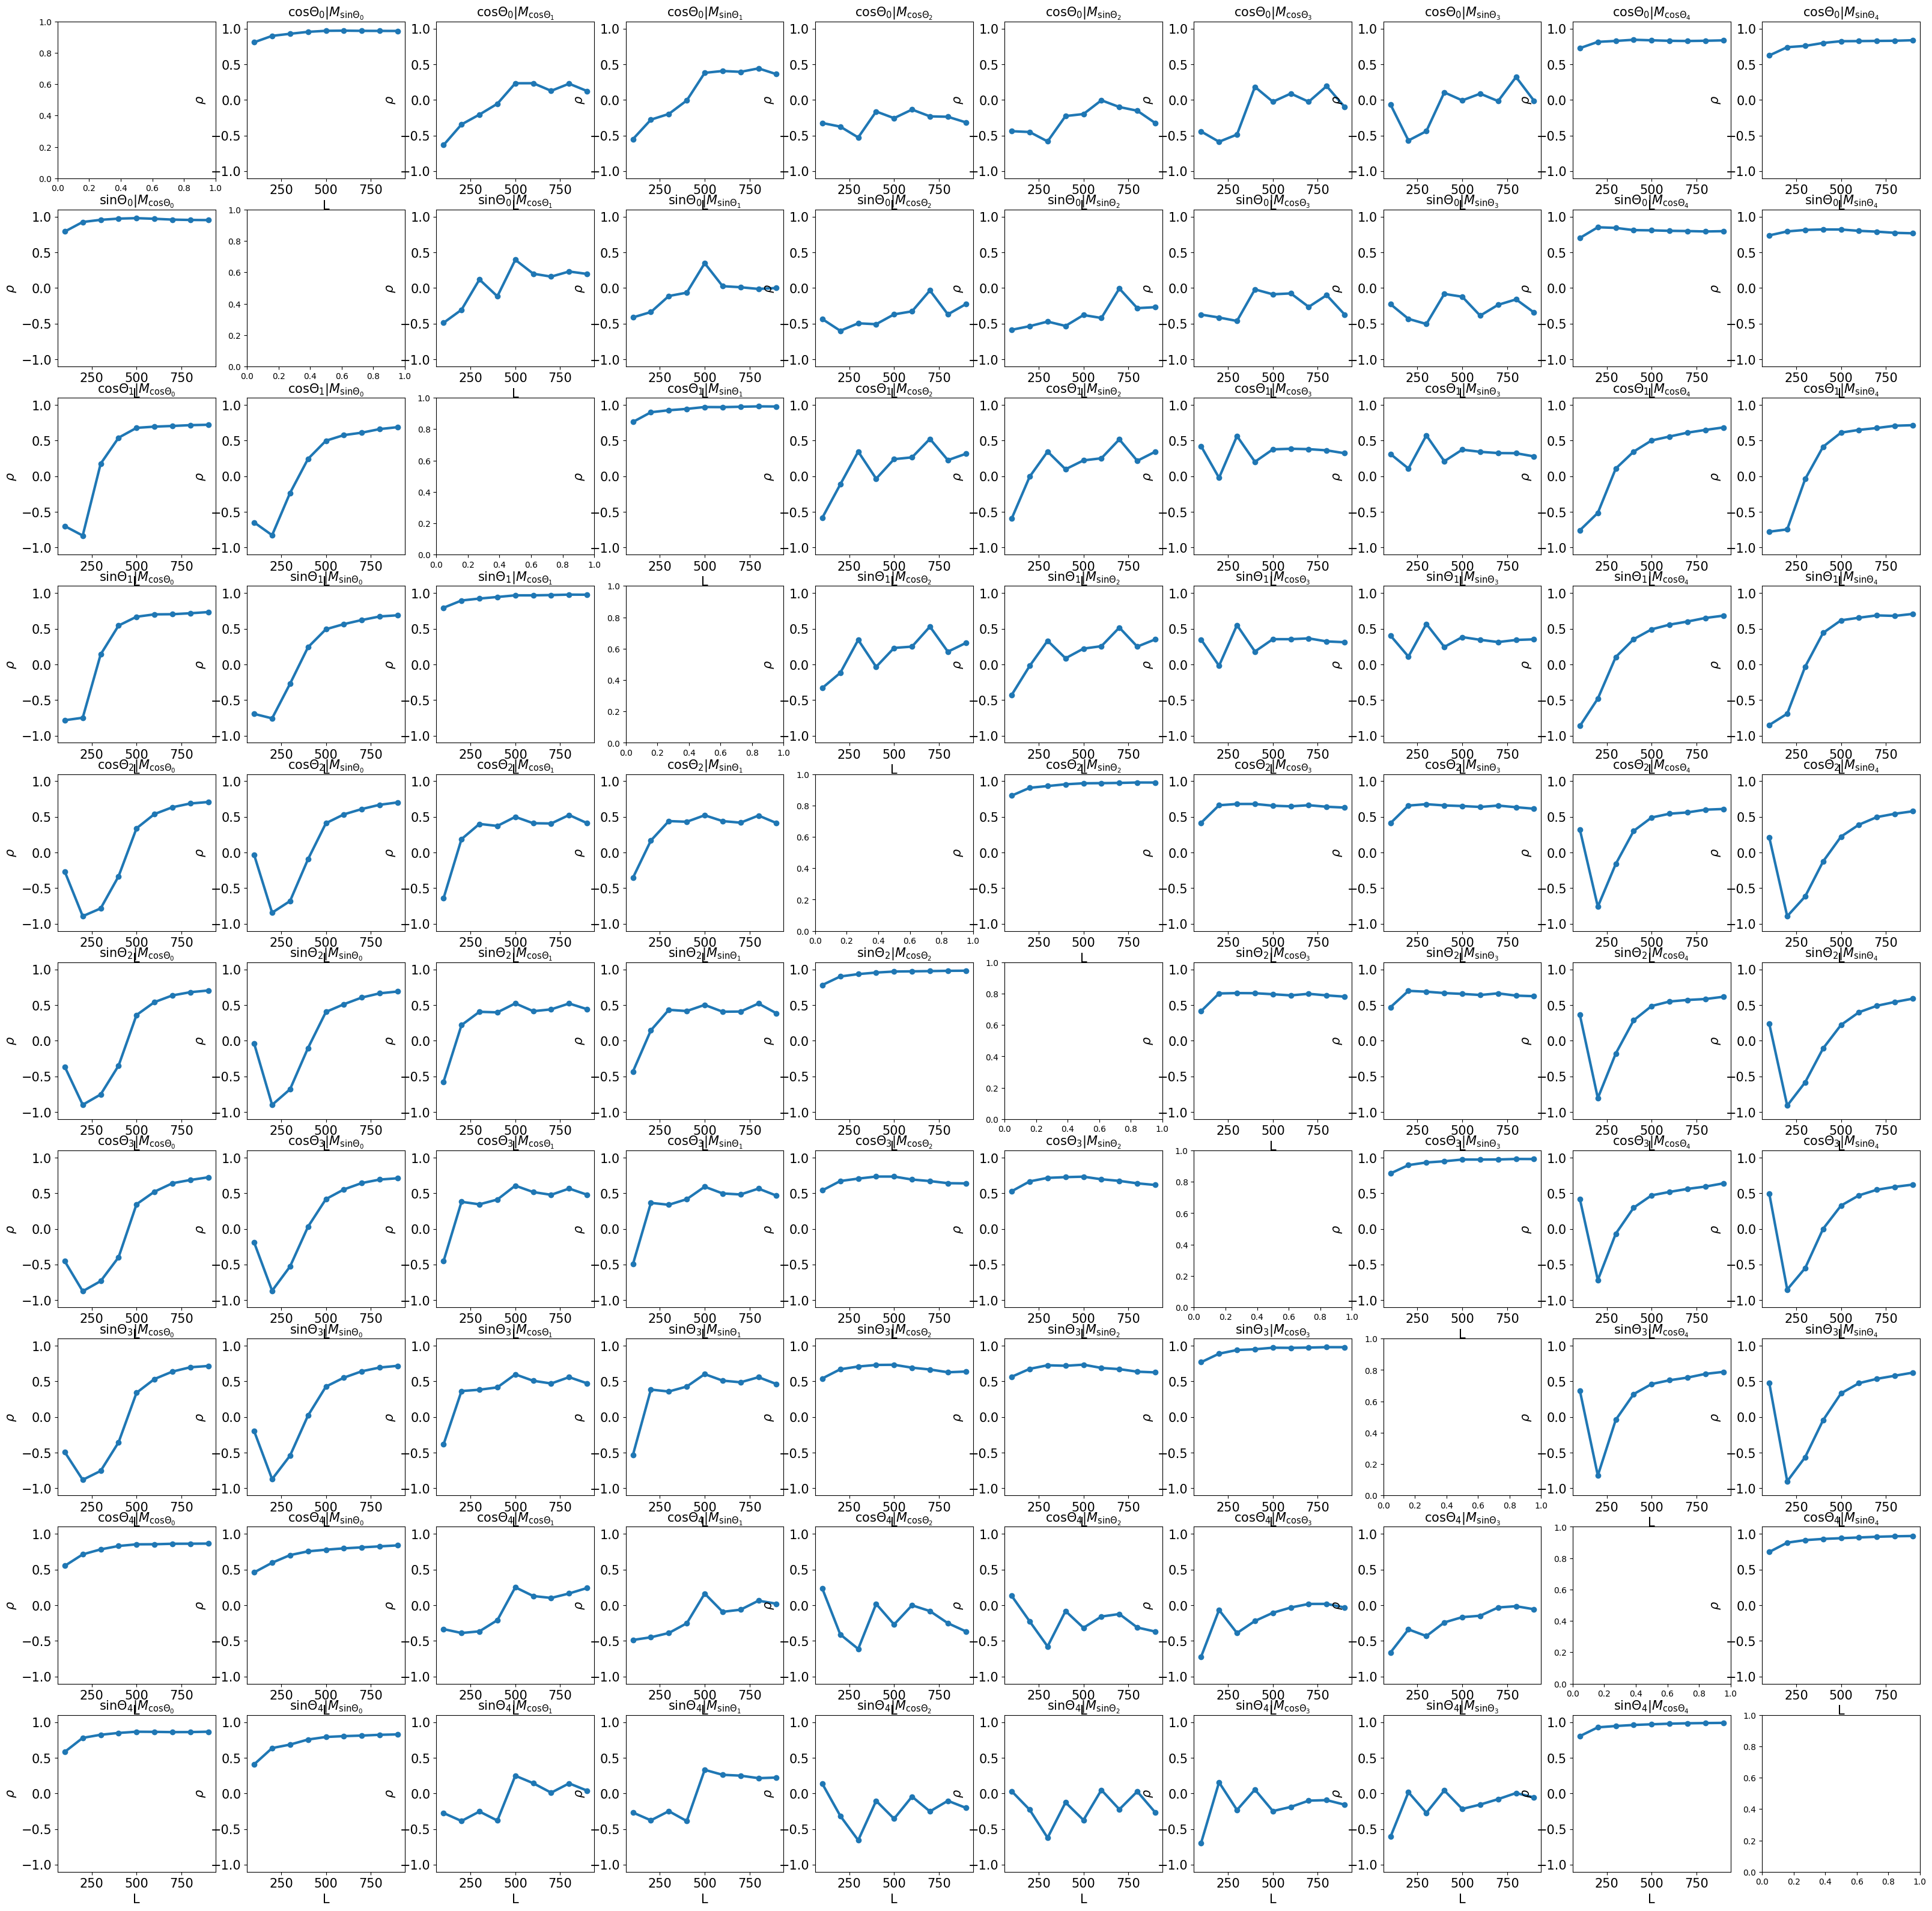

In [32]:
#plot parameters
plt.rcParams['figure.figsize'] = [40,40]

#parameters for generate_multiple_correlation_plots
E=2*2*N+1
tau=1
filename = '/Users/aarcher/PycharmProjects/Data Driven Dynamical Systems/Kuramoto/pictures/strong_coupling_transformed_kuramoto'
generate_multiple_correlation_plots(plt,y_transform,E,tau,names,filename)

# Weak Coupling

In [33]:
# these are our constants
N = 5  # number of variables
K = 1.0 #coupling
omega =  np.array([ 2.31246433, 35.50794494, 53.41350736, 50.23353682,  5.63392492])  # natural frequency
theta0 = np.array([1.1735002435, 2.6194283291, 2.6006912657, 2.9369995793,2.3511319532]) # initial state 
tinit = 0.0
tmax = 10.0
dt =  0.01

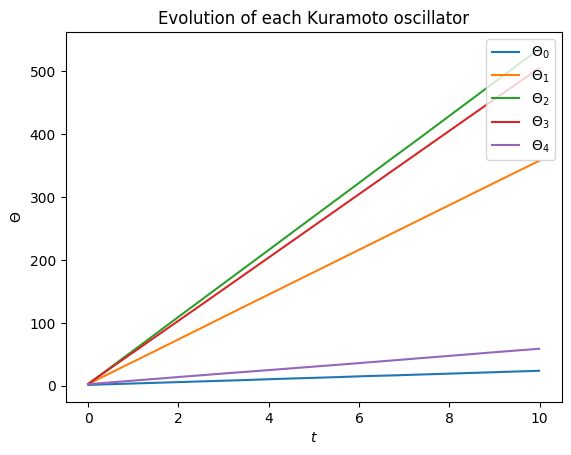

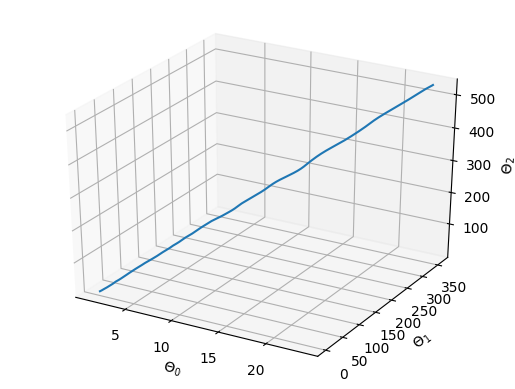

In [34]:
kuramoto = Kuramoto(N,K,omega)
sol = kuramoto.integrate(tinit, tmax, dt, theta0)
kuramoto.evolution_plot()
kuramoto.trajectory_plot()

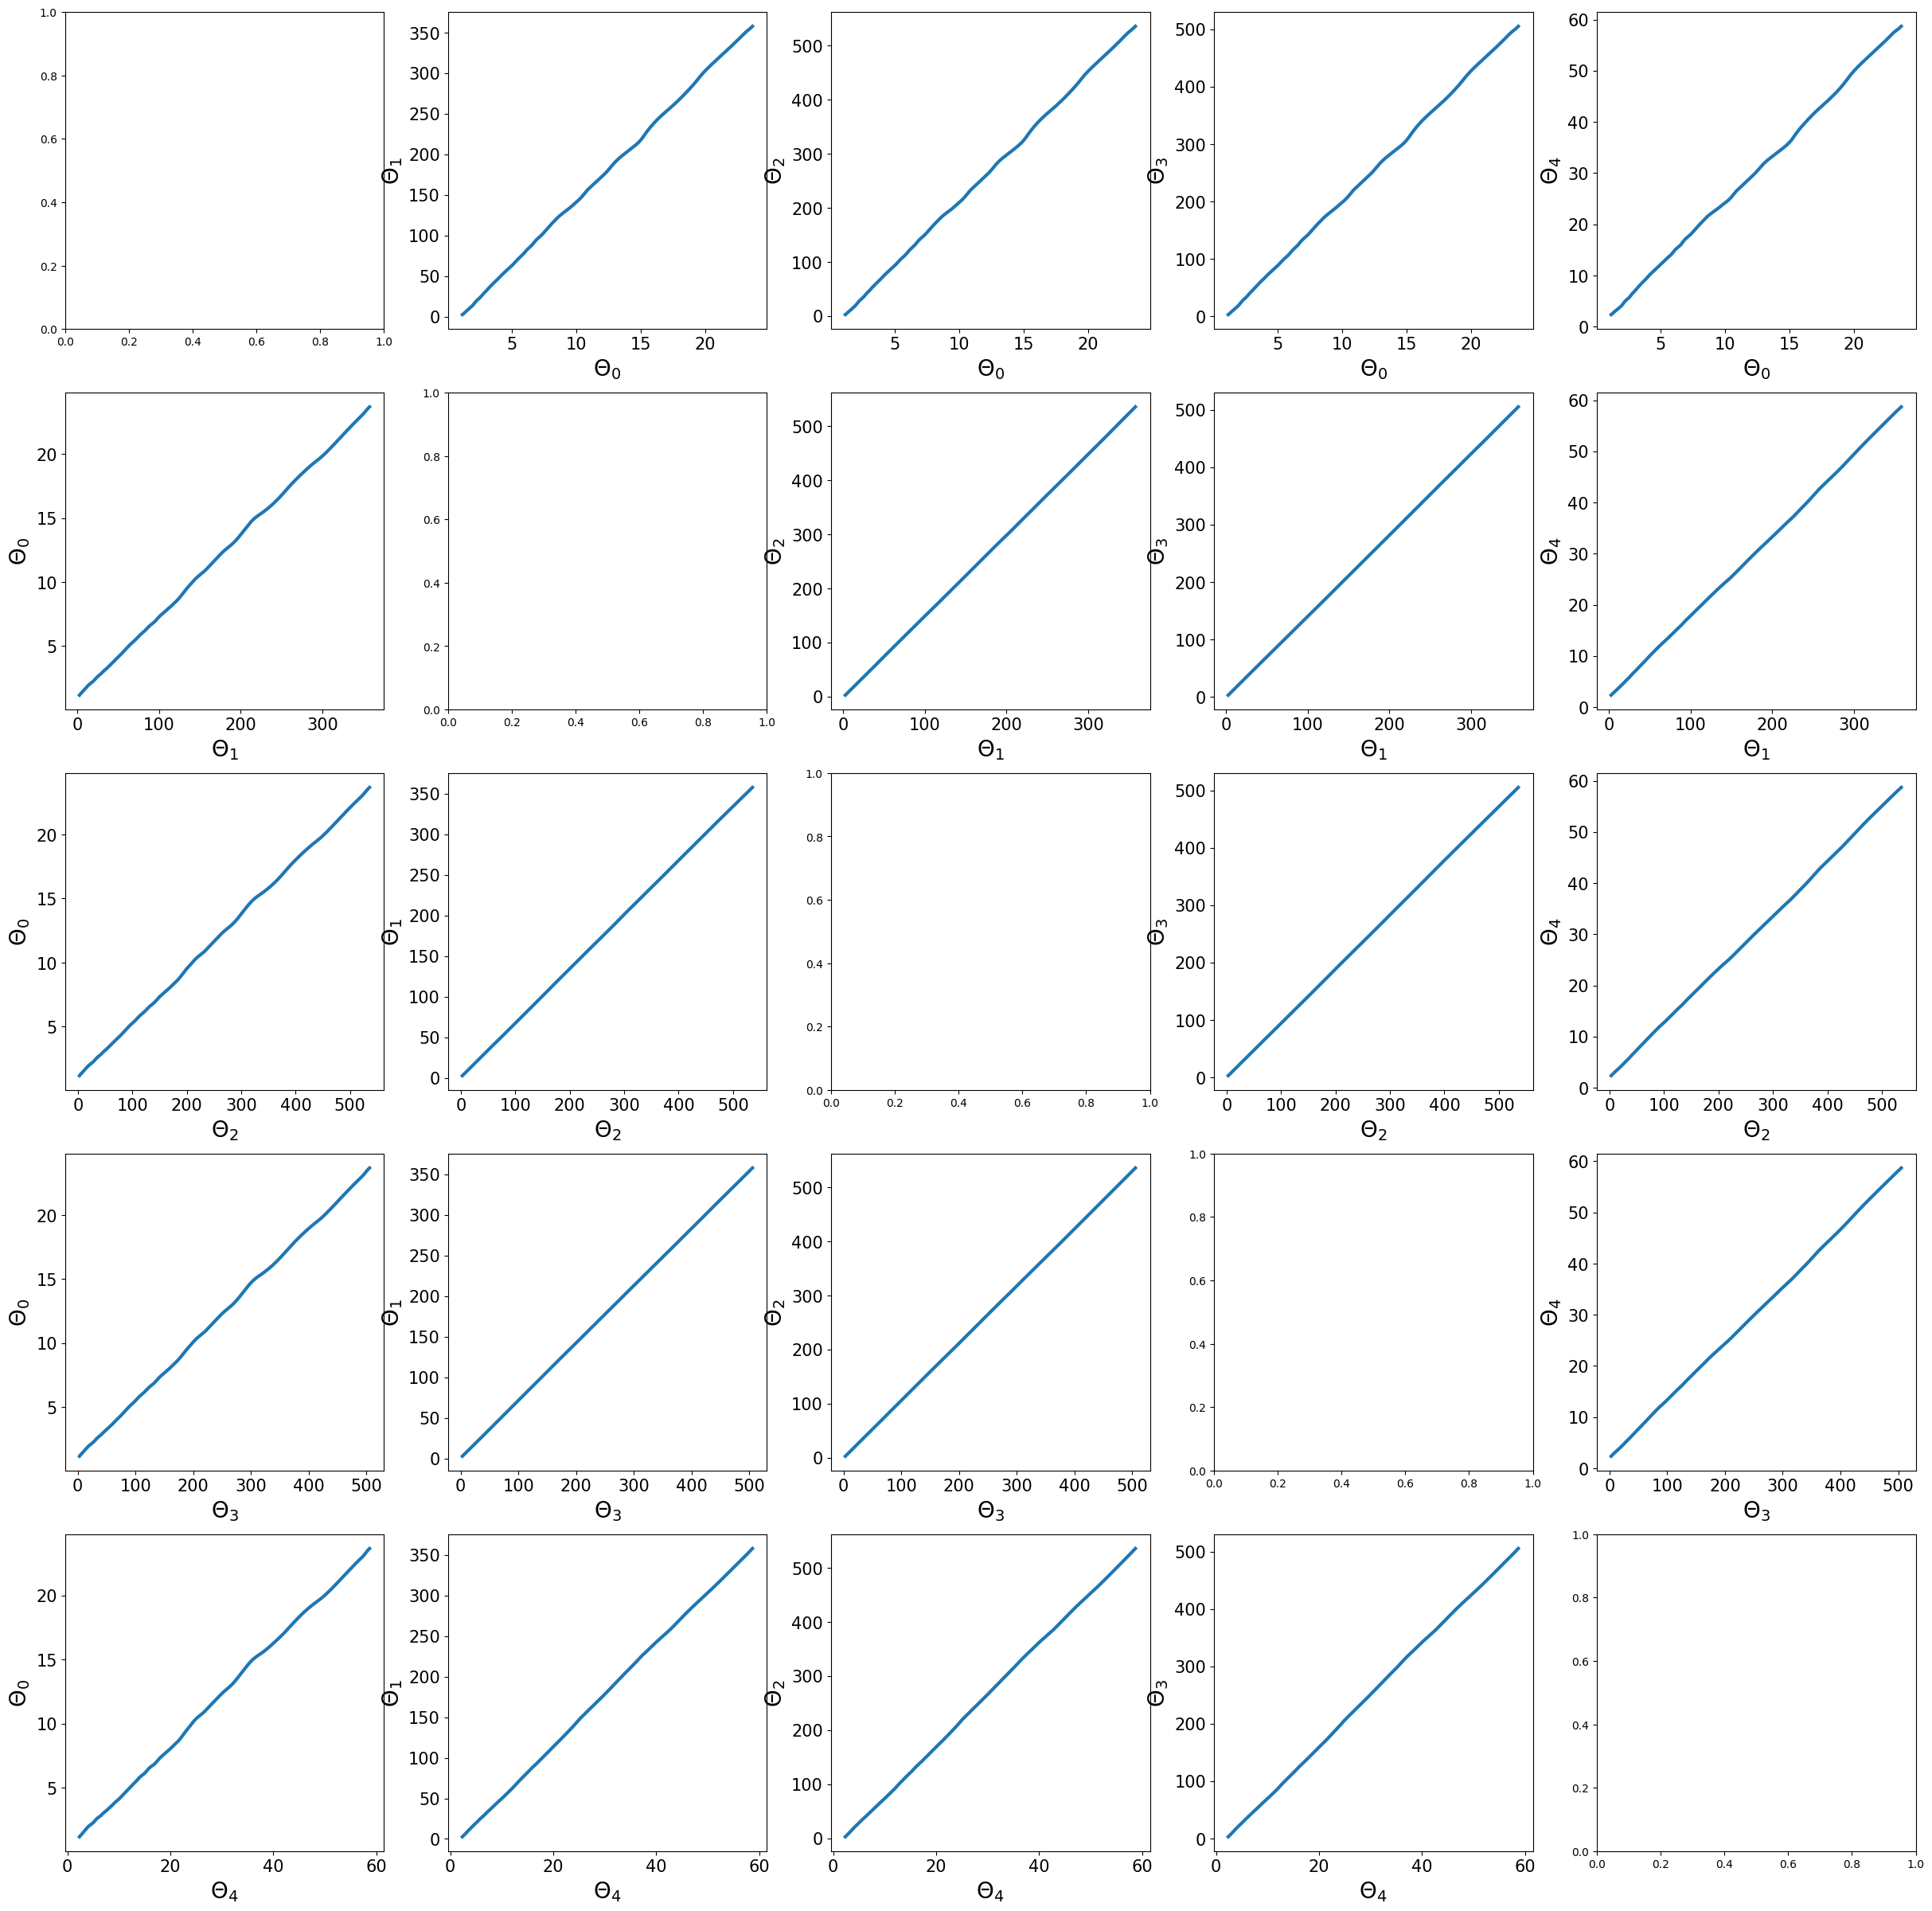

In [35]:
#reset plot 
plt.cla()
plt.clf()
plt.close()

plt.rcParams['figure.figsize'] = [30,30]

# generate_phase_plane_plots parameters
y = sol[1].T
total_len =y.shape[1]
names =  ['\Theta_0','\Theta_1', '\Theta_2','\Theta_3','\Theta_4']


generate_phase_plane_plots(plt,y,names)

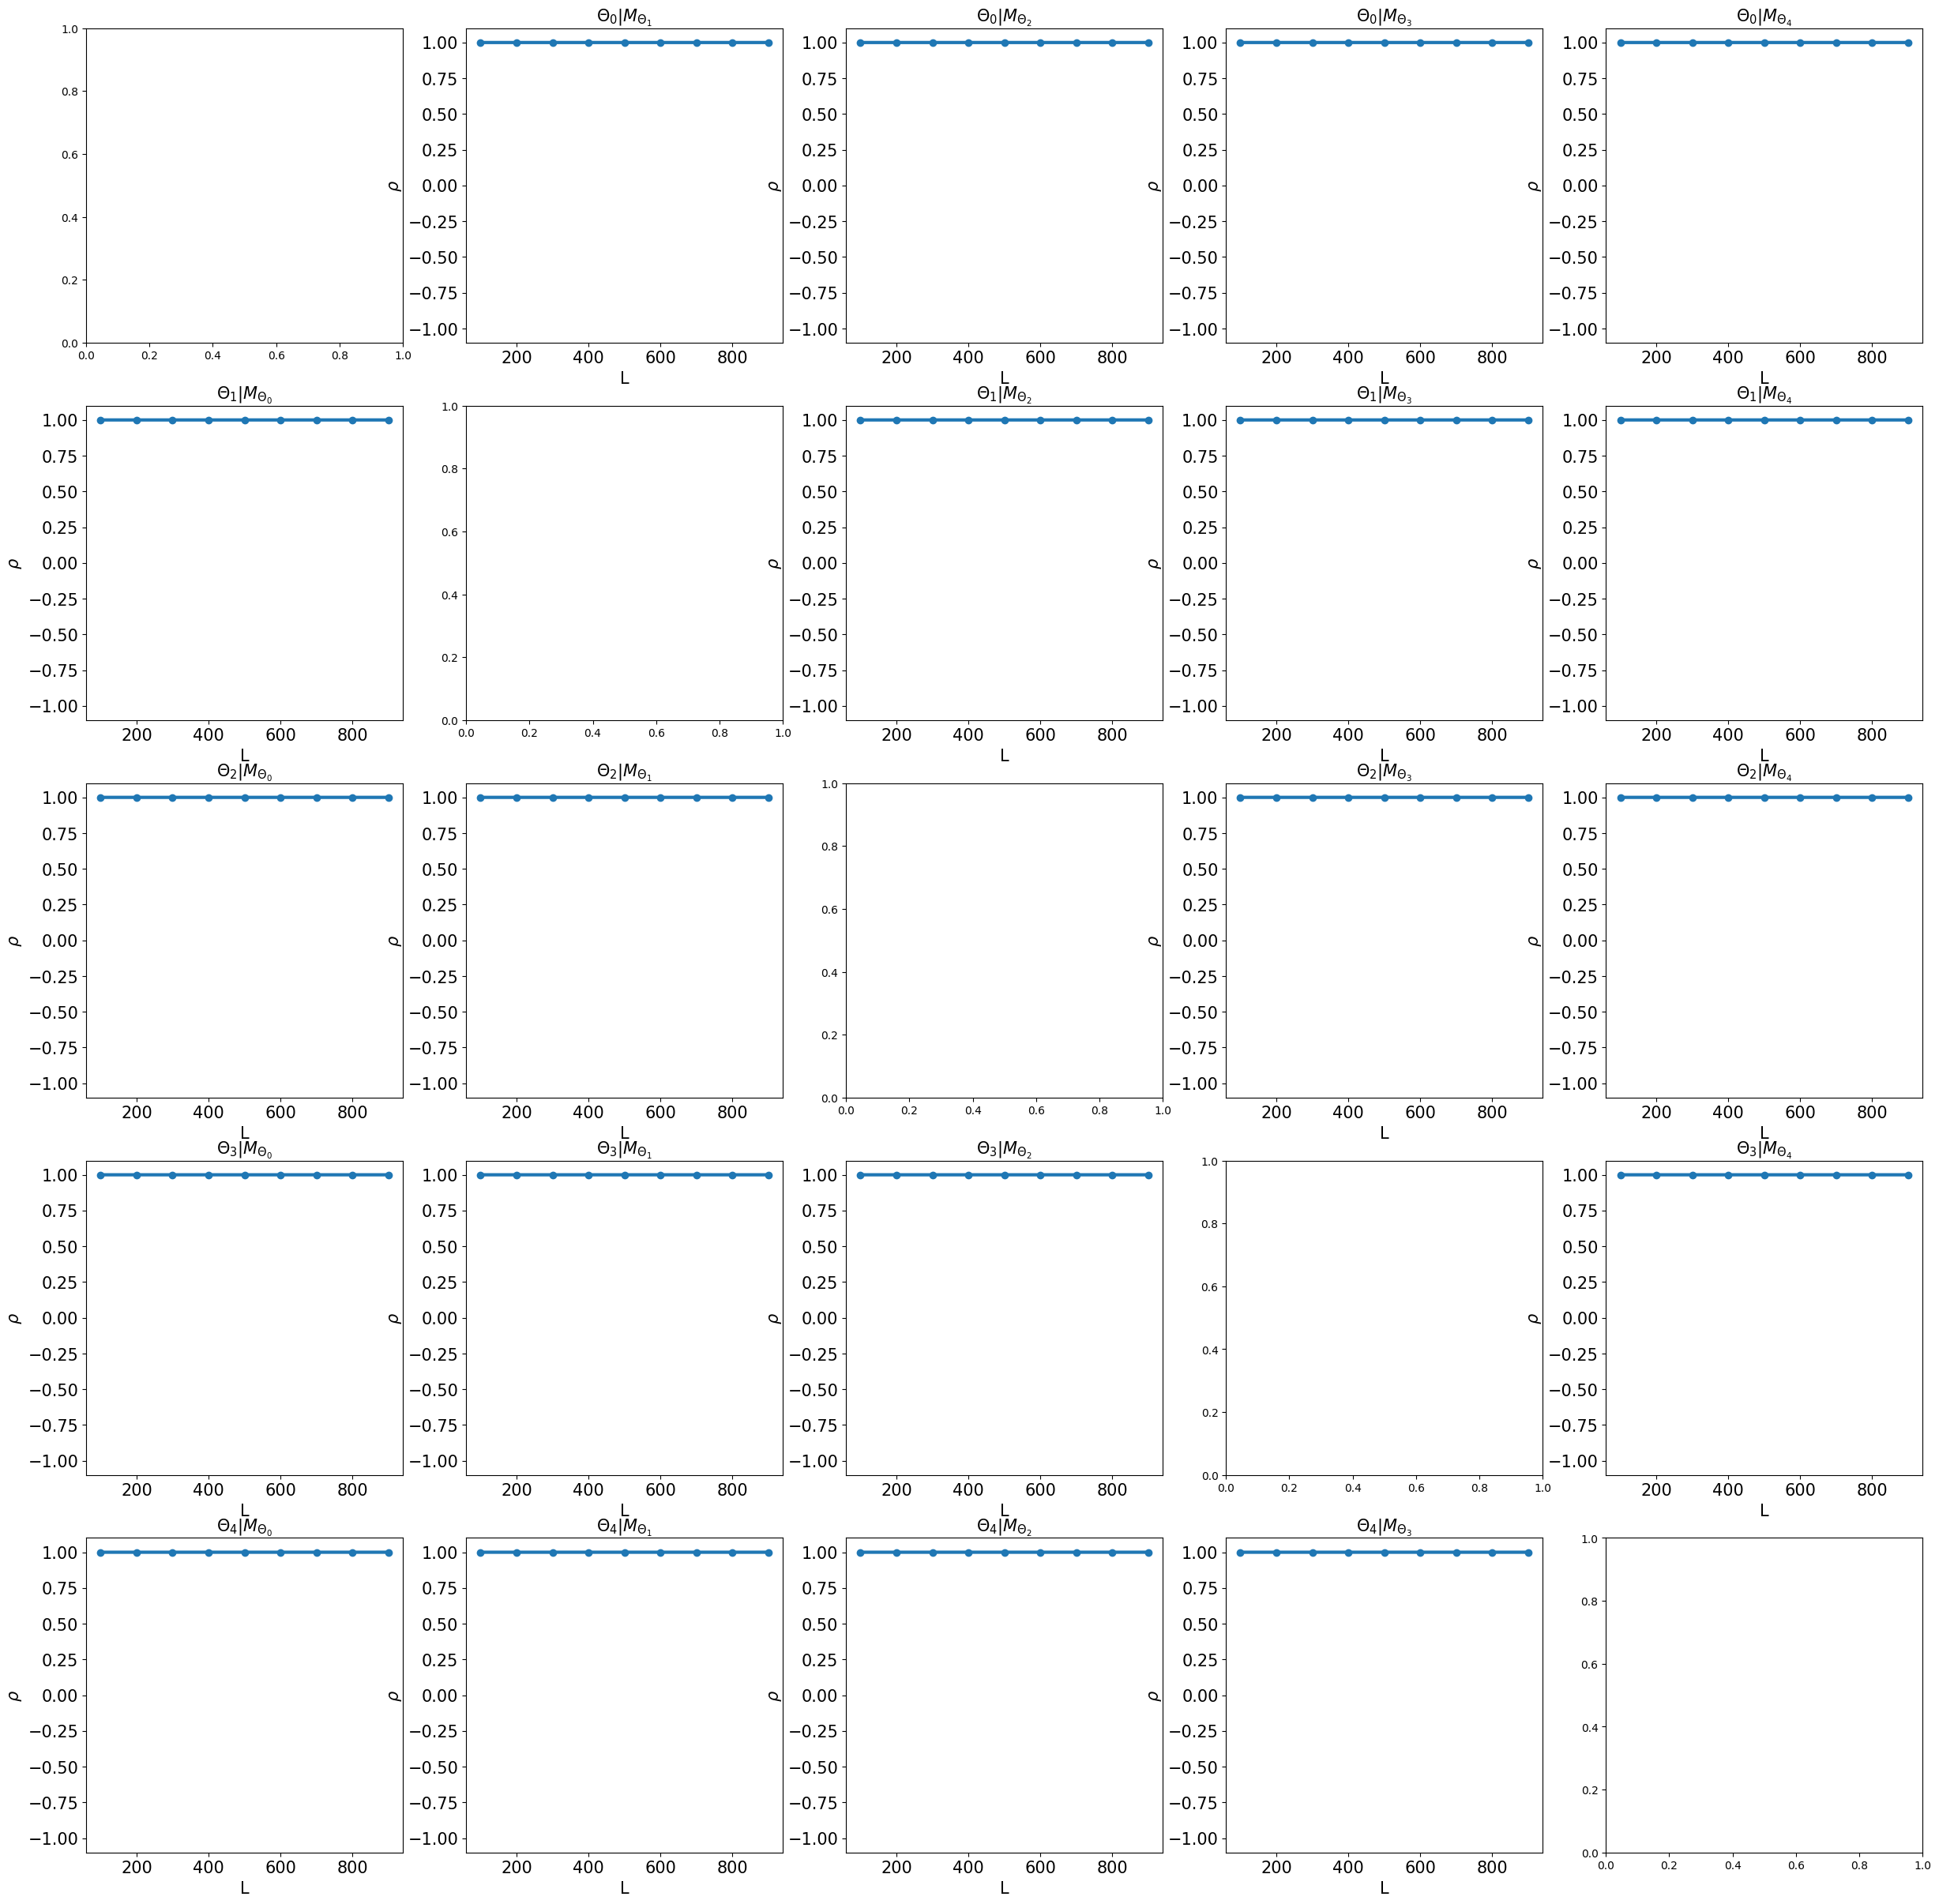

In [36]:
#reset plots
plt.cla()
plt.clf()
plt.close()

#plot parameters
plt.rcParams['figure.figsize'] = [30,30]

#parameters for generate_multiple_correlation_plots
names =  ['\Theta_0','\Theta_1', '\Theta_2','\Theta_3','\Theta_4']
E=2*N+1
tau=1
filename = '/Users/aarcher/PycharmProjects/Data Driven Dynamical Systems/Kuramoto/pictures/weak_coupling_kuramoto'
generate_multiple_correlation_plots(plt,y,E,tau,names,filename)

## Transformed Problem

In [37]:
kuramoto_df = pd.DataFrame(data= sol[1],    
                columns=['\Theta_0','\Theta_1','\Theta_2','\Theta_3','\Theta_4'])
kuramoto_transform_df = kuramoto_df.transform([np.cos,np.sin])
kuramoto_transform_df.columns = [''.join(['\\' + col[1] + col[0]]).strip() for col in kuramoto_transform_df.columns.values]

In [38]:
names = kuramoto_transform_df.columns.values
y_transform = (kuramoto_transform_df.values).T
#reset plots
plt.cla()
plt.clf()
plt.close()

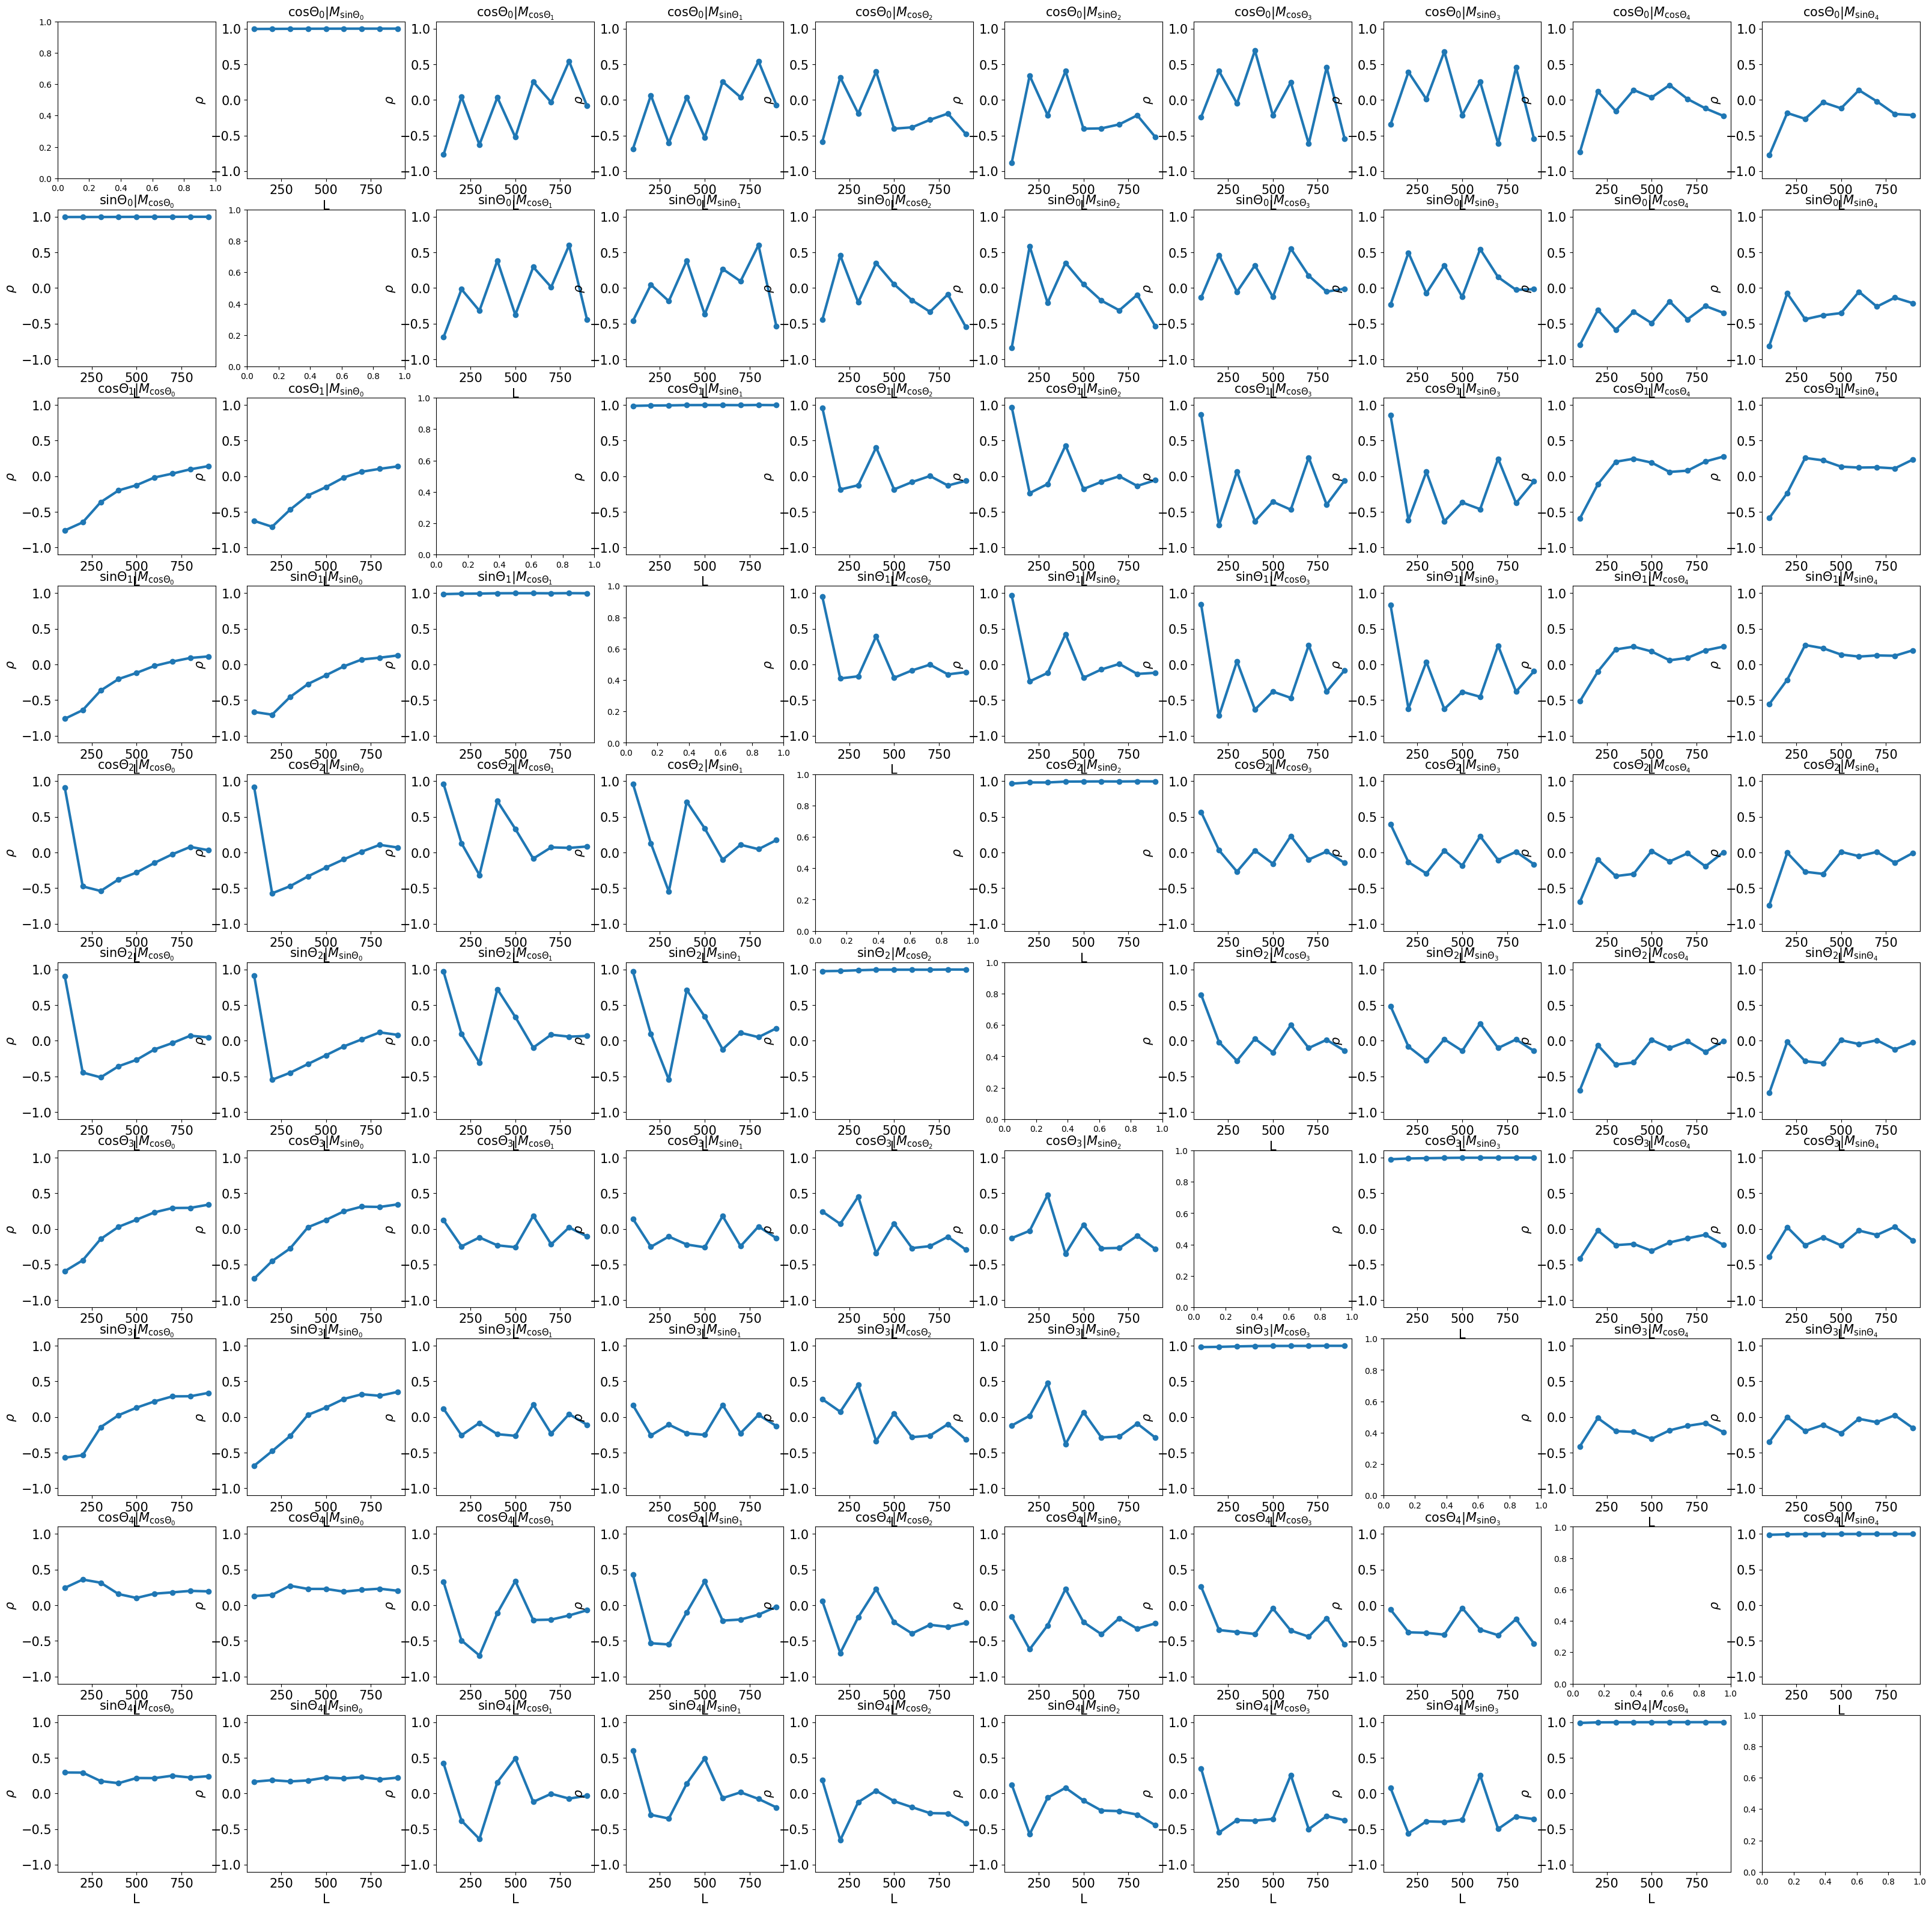

In [39]:
#plot parameters
plt.rcParams['figure.figsize'] = [40,40]

#parameters for generate_multiple_correlation_plots
E=2*2*N+1
tau=1
filename = '/Users/aarcher/PycharmProjects/Data Driven Dynamical Systems/Kuramoto/pictures/weak_coupling_transformed_kuramoto'
generate_multiple_correlation_plots(plt,y_transform,E,tau,names,filename)

## No Coupling 

In [40]:
# these are our constants
N = 5  # number of variables
K = 0 #coupling
omega =  np.array([ 2.31246433, 35.50794494, 53.41350736, 50.23353682,  5.63392492])  # natural frequency
theta0 = np.array([1.1735002435, 2.6194283291, 2.6006912657, 2.9369995793,2.3511319532]) # initial state 
tinit = 0.0
tmax = 10.0
dt =  0.01

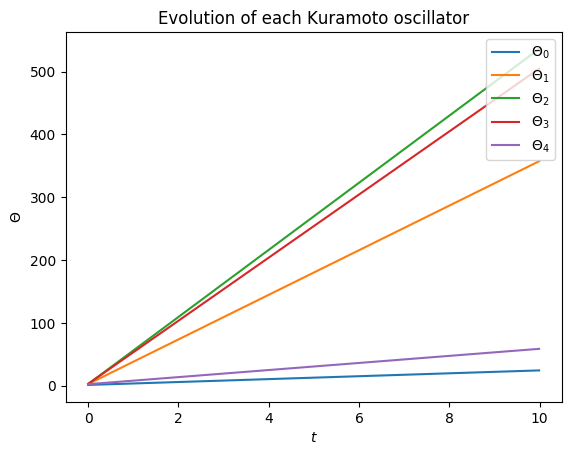

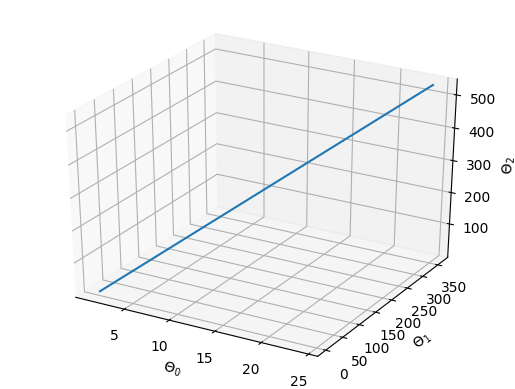

In [41]:
kuramoto = Kuramoto(N,K,omega)
sol = kuramoto.integrate(tinit, tmax, dt, theta0)
kuramoto.evolution_plot()
kuramoto.trajectory_plot()

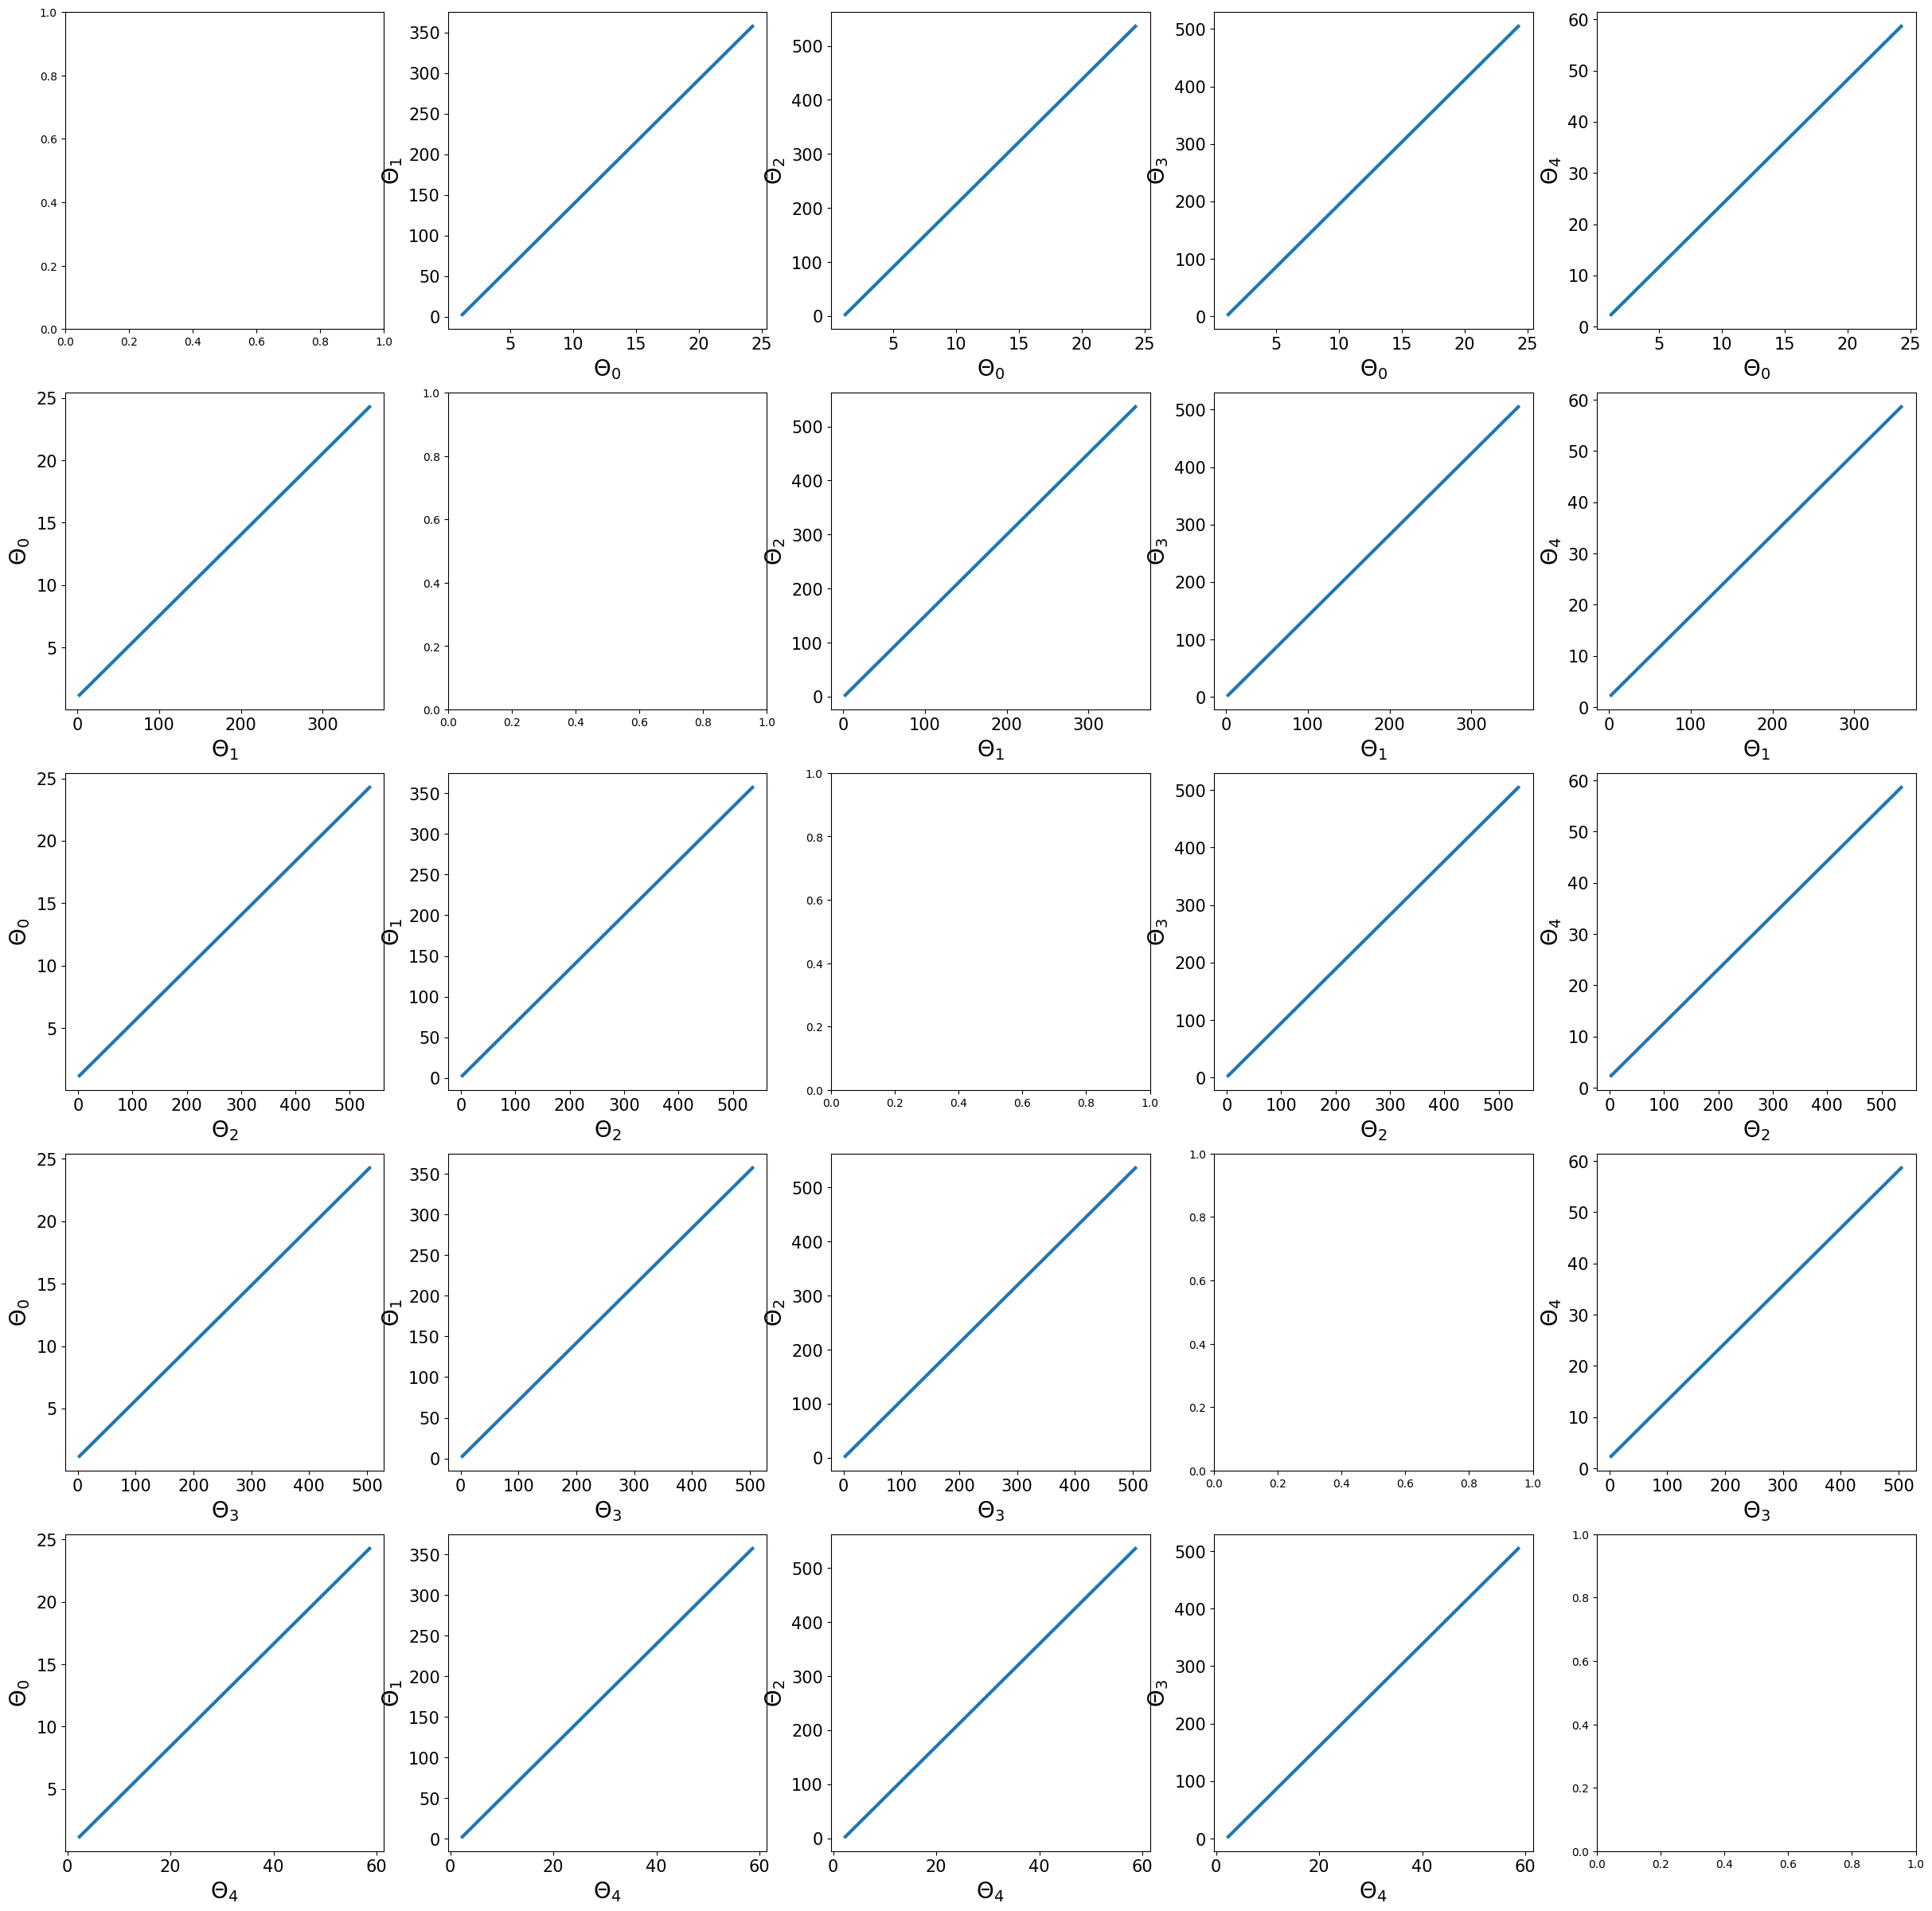

In [42]:
#reset plot 
plt.cla()
plt.clf()
plt.close()

plt.rcParams['figure.figsize'] = [30,30]

# generate_phase_plane_plots parameters
y = sol[1].T
total_len =y.shape[1]

names =  ['\Theta_0','\Theta_1', '\Theta_2','\Theta_3','\Theta_4']

generate_phase_plane_plots(plt,y,names)

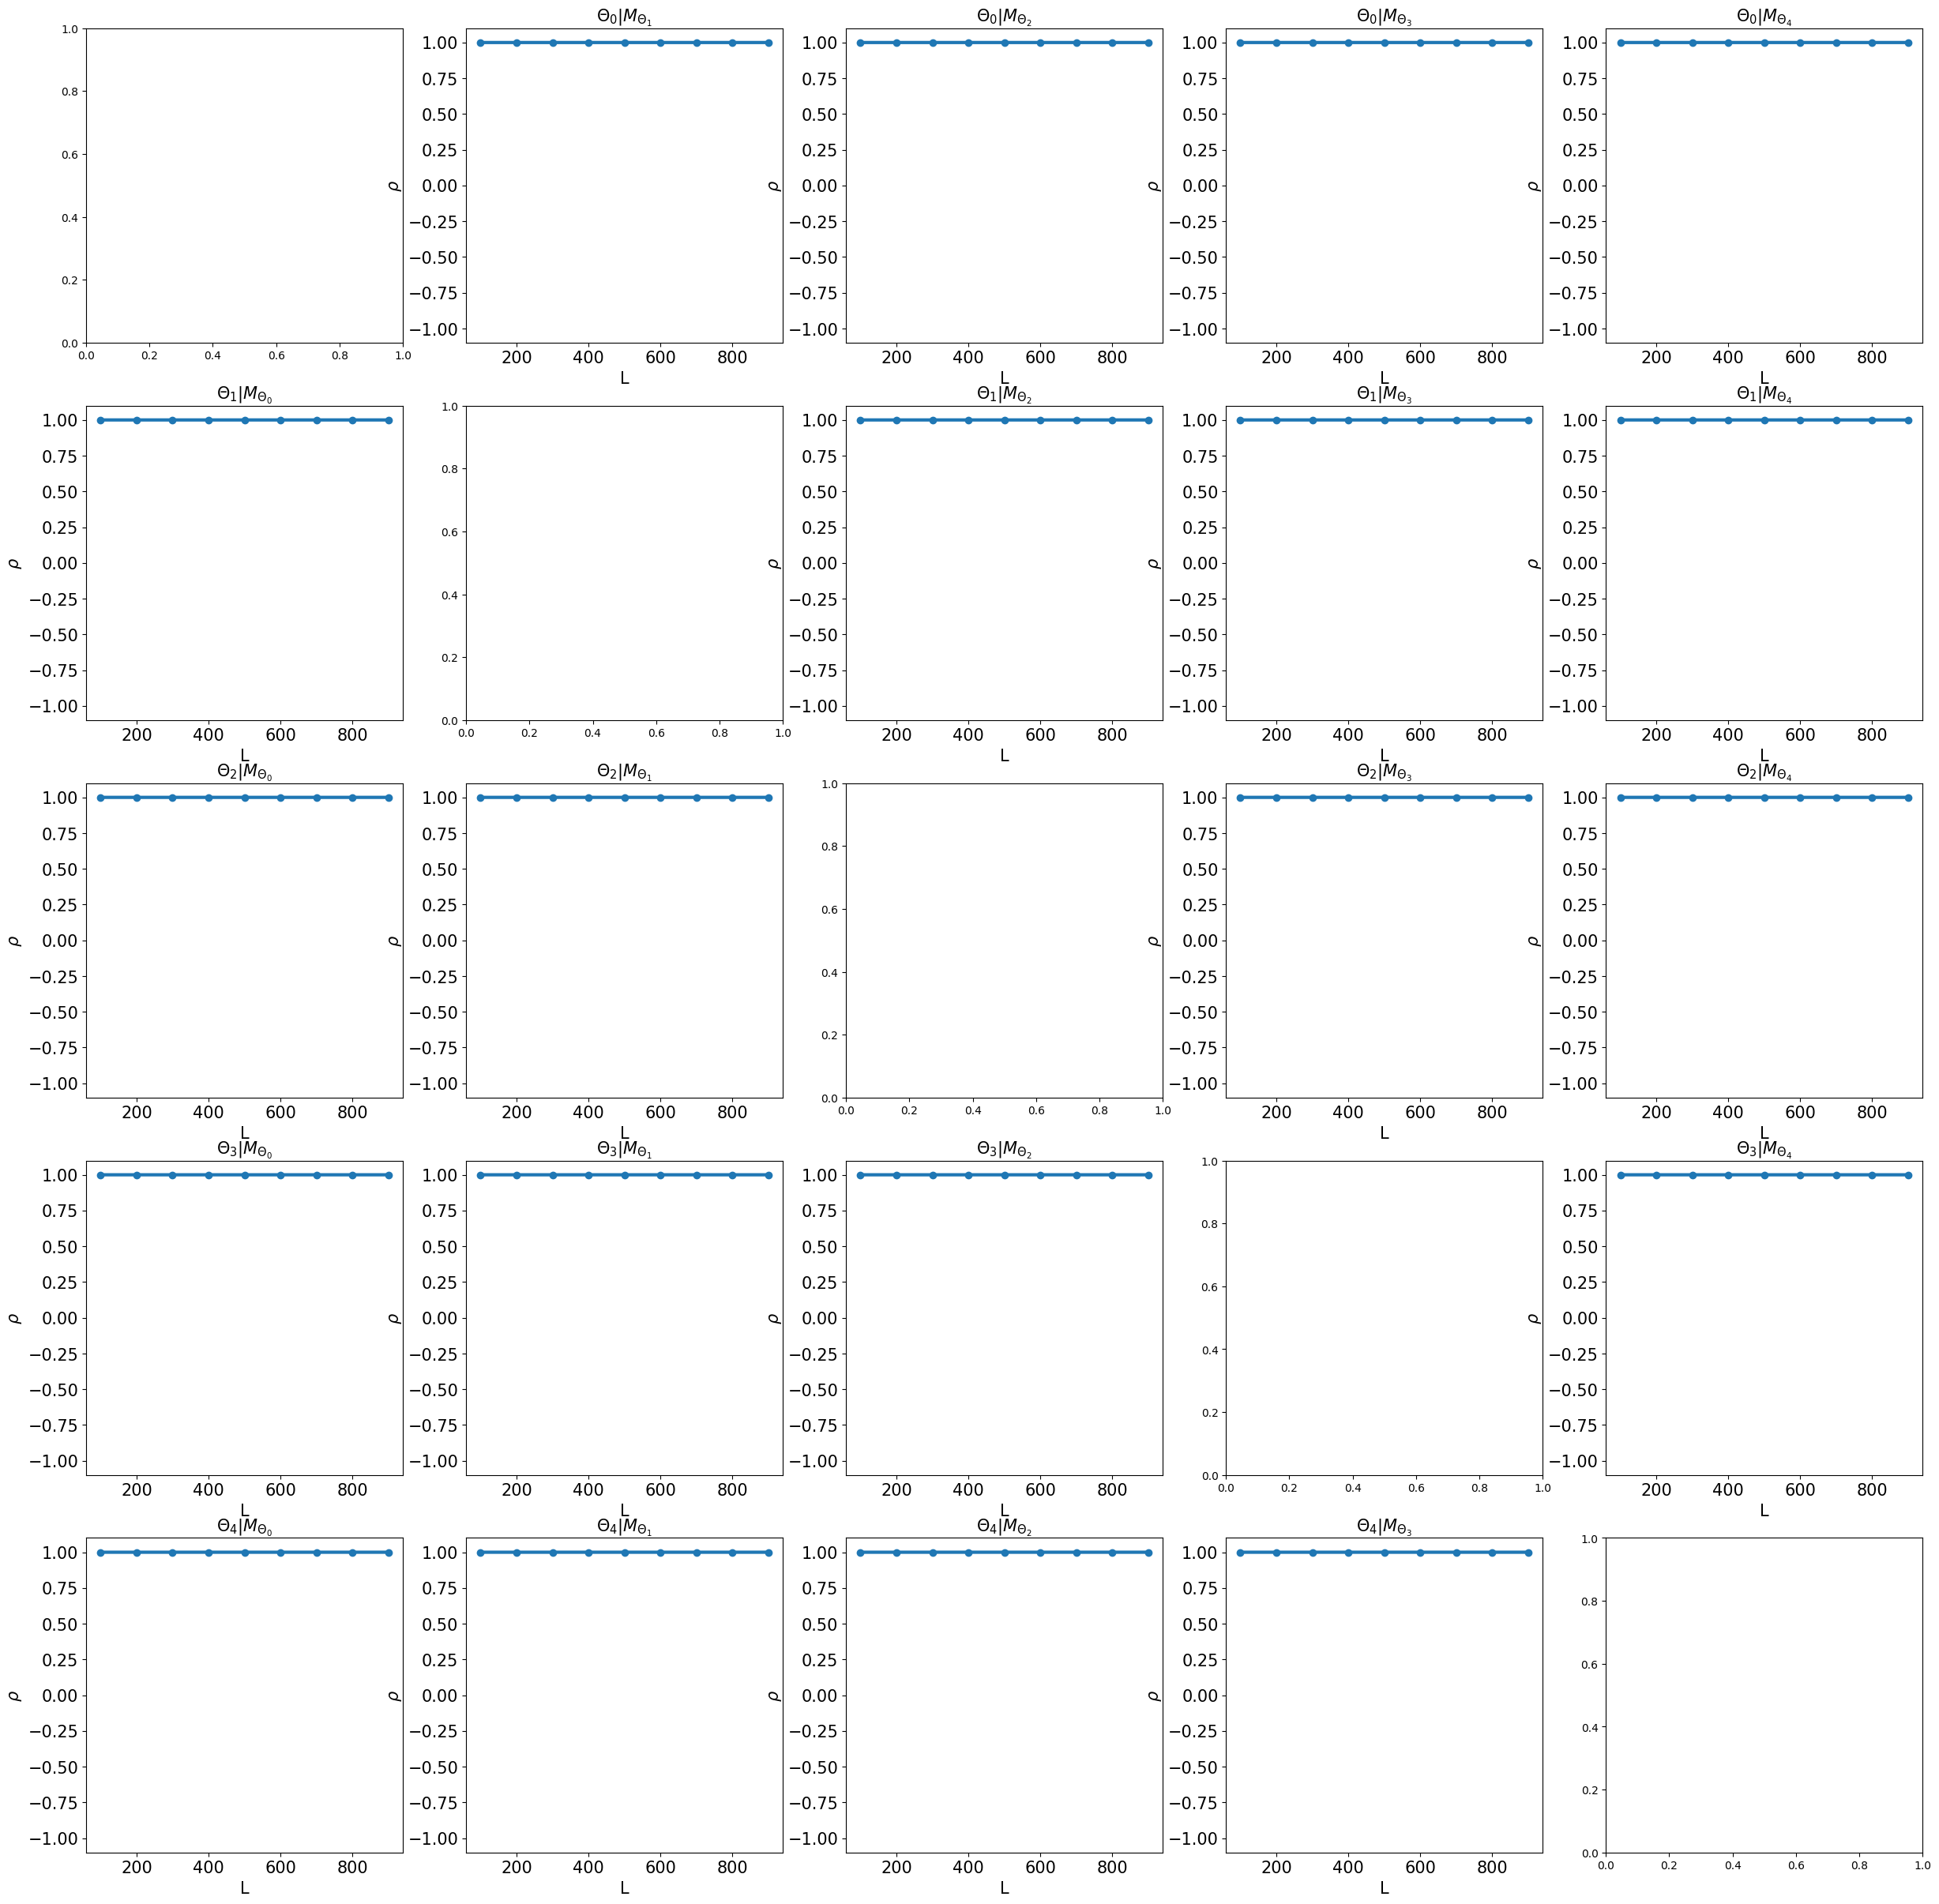

In [43]:
#reset plots
plt.cla()
plt.clf()
plt.close()

#plot parameters
plt.rcParams['figure.figsize'] = [30,30]

#parameters for generate_multiple_correlation_plots
names =  ['\Theta_0','\Theta_1', '\Theta_2','\Theta_3','\Theta_4']
E=2*N+1
tau=1
filename = '/Users/aarcher/PycharmProjects/Data Driven Dynamical Systems/Kuramoto/pictures/no_coupling_kuramoto'
generate_multiple_correlation_plots(plt,y,E,tau,names,filename)

## Transformed Problem

In [44]:
kuramoto_df = pd.DataFrame(data= sol[1],    
                columns=['\Theta_0','\Theta_1','\Theta_2','\Theta_3','\Theta_4'])
kuramoto_transform_df = kuramoto_df.transform([np.cos,np.sin])
kuramoto_transform_df.columns = [''.join(['\\' + col[1] + col[0]]).strip() for col in kuramoto_transform_df.columns.values]

In [45]:
names = kuramoto_transform_df.columns.values
y_transform = (kuramoto_transform_df.values).T
#reset plots
plt.cla()
plt.clf()
plt.close()

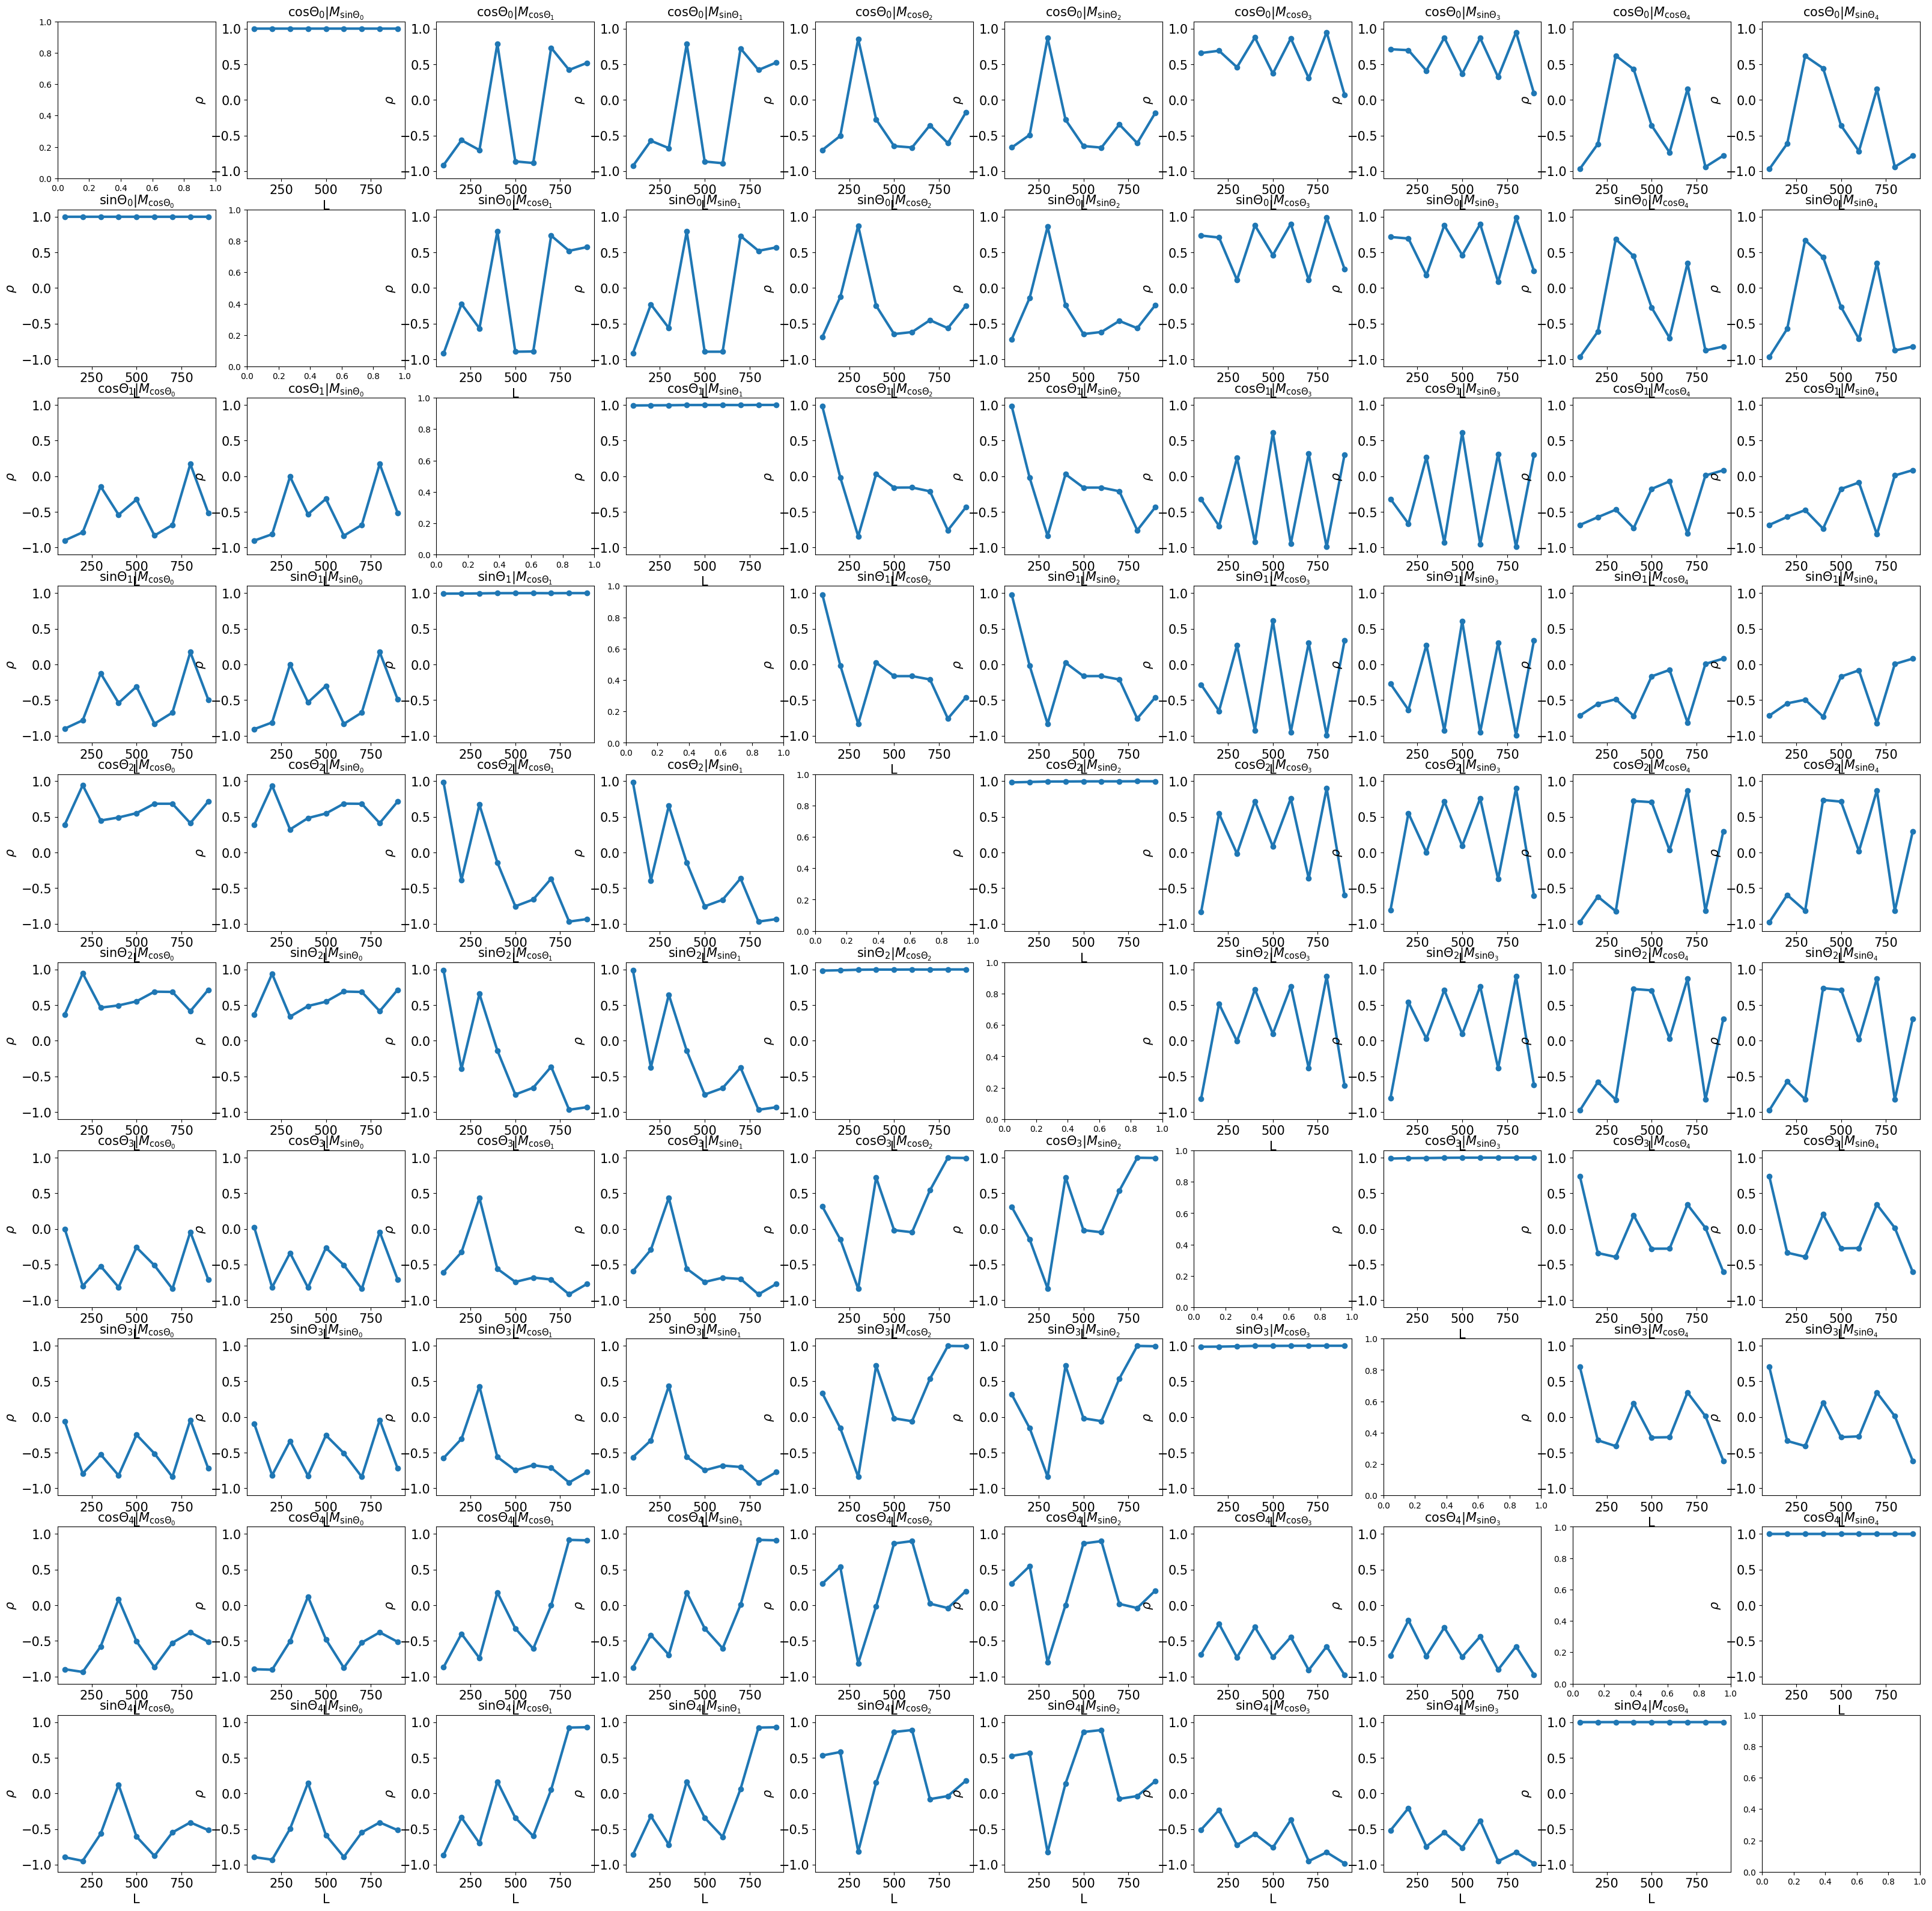

In [46]:
#plot parameters
plt.rcParams['figure.figsize'] = [40,40]

#parameters for generate_multiple_correlation_plots
E=2*2*N+1
tau=1
filename = '/Users/aarcher/PycharmProjects/Data Driven Dynamical Systems/Kuramoto/pictures/no_coupling_transformed_kuramoto'
generate_multiple_correlation_plots(plt,y_transform,E,tau,names,filename)